# Nano-gpt forecasting

Using series data to predict an item 5 time steps ahead.

In [1]:

from tqdm import tqdm
import os
from typing import List
import time
import math
from contextlib import nullcontext

import numpy as np
import pandas as pd
import torch
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.distributed import init_process_group, destroy_process_group

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import umap.umap_ as umap

from gpt_model import *

In [2]:
# Variables

from config import KEY, PERIOD, TARGET_PERIOD, STORE_PATH, SEQ_TYPE, \
    TRANS_TYPE, VAL_LIMIT, NORM_SIZE

In [3]:

# Build fp
fields = [KEY, SEQ_TYPE]
DATA_FP = "_".join(fields)+".np"
VAL_DATA_FP = "_".join(fields+["val"])+".np"
fields = [KEY, SEQ_TYPE, f"period{PERIOD}", f"pred{TARGET_PERIOD}"]
if TRANS_TYPE == "norm":
    fields += ["norm", f"normsize{NORM_SIZE}"]
elif TRANS_TYPE:
    fields += [TRANS_TYPE]
MODEL_FP = "_".join(fields)+".pt"
fp = os.path.join(STORE_PATH, DATA_FP)
val_fp = os.path.join(STORE_PATH, VAL_DATA_FP)
model_fp = os.path.join(STORE_PATH, MODEL_FP)
model_fp

'C:/Users/robert.franklin/Desktop/local_projects/random/stock-gpt/data/close_single_long_period30_pred1_norm_normsize30.pt'

In [4]:
# Import the data
data = np.load(fp)
val_data = np.load(val_fp)

In [5]:
# Replace nan
train_data = np.where(np.isnan(data), -1, data)
val_data = np.where(np.isnan(val_data), -1, val_data)

In [6]:

# Convert to tensor
train_data = torch.tensor(train_data, dtype=torch.float32)
val_data = torch.tensor(val_data, dtype=torch.float32)
print(f"train and val data shape: {train_data.shape[0]:,.0f} and {val_data.shape[0]:,.0f}")

train and val data shape: 746 and 746


In [7]:
# Transformation methods
def trans_norm(t: torch.Tensor, norm_size:int = NORM_SIZE) -> torch.Tensor:
    # Limit the normalisation group to block_size
    # This will allow for values >1 and <0 in the block
    lim = norm_size if t.shape[1] > norm_size else None
    t_lim = t[:, :lim]
    maxs = (torch.max(
        torch.where(~t_lim.isnan(), t_lim, -torch.inf),
        axis=1
    ).values * torch.ones_like(t.T)).T
    mins = (torch.min(
        torch.where(~t_lim.isnan(), t_lim, torch.inf),
        axis=1
    ).values * torch.ones_like(t.T)).T
    out = ((t - mins) / (maxs - mins))
    # Avoid inf 
    # (this will happen where it's the same number throughout)
    out = torch.where(
        out != torch.inf,
        out, 0
    )
    # Set a max and min limit
    if VAL_LIMIT is not None:
        out = torch.where(out > VAL_LIMIT, VAL_LIMIT, out)
        out = torch.where(out < -VAL_LIMIT, -VAL_LIMIT, out)
    # Convert inf to torch.nan
    out = out.nan_to_num(VAL_LIMIT, neginf=VAL_LIMIT, posinf=VAL_LIMIT)
    return out

def trans_norm_to_first(t: torch.Tensor) -> torch.Tensor:
    t2 = t[:, 0]
    t2 = (t2 * torch.ones_like(t.T)).T
    t = t / t2
    return t

def trans_log(t: torch.Tensor) -> torch.Tensor:
    return torch.log(t.nan_to_num(0, neginf=0, posinf=0))

def trans_inf(t: torch.Tensor) -> torch.Tensor:
    return t.nan_to_num(0, neginf=-1, posinf=1)

# Set the function
if TRANS_TYPE == "norm":
    trans_func = trans_norm
elif TRANS_TYPE == "norm_to_first":
    trans_func = trans_norm_to_first
elif TRANS_TYPE == "log":
    trans_func = trans_log
else:
    trans_func = trans_inf

In [8]:
# data loading
def generate_samples(data: torch.Tensor,
                     batch_size:int,
                     block_size:int,
                     steps:int,
                     ) -> List[torch.Tensor]:
    samples = torch.Tensor()
    n = 0
    while samples.shape[0] < batch_size:
        sample_size = batch_size - samples.shape[0]
        ix1 = torch.randint(data.shape[0], (sample_size, ))
        ix2 = torch.randint(data.shape[1] - (block_size+steps), (sample_size, ))
        ix = torch.stack([ix1, ix2], dim=1)
        new_samples = torch.stack([data[i, j:j+block_size+steps] for i, j in ix])
        # Keep only where it is not full of nan or the same values
        new_samples = new_samples[
            ~torch.isnan(new_samples).all(axis=1)
            & (new_samples.max(axis=1).values != new_samples.min(axis=1).values)
            ]
        samples = torch.cat([samples, new_samples])
        n += 1
        if n > 100:
            raise Exception("Could not find enough samples")
    return samples

def get_batch(
        split,
        step: int = 1,
        trans_func: callable = lambda x: x,
        *args,
        **kwargs
        ) -> List[torch.Tensor]:
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    batch = generate_samples(data, batch_size, PERIOD, step)
    # Normalise
    batch = trans_func(batch, *args , **kwargs)
    # Split into x and y
    x = batch[:, :block_size]
    y = batch[:, step:block_size+step]
    if device == 'cuda':
        # pin arrays x,y, which allows us to move them to GPU asynchronously (non_blocking=True)
        x, y = x.pin_memory().to(device, non_blocking=True), y.pin_memory().to(
            device, non_blocking=True)
    else:
        x, y = x.to(device), y.to(device)
    return x, y

In [9]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta) \
            or np.isnan(validation_loss):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [10]:

# various inits, derived attributes, I/O setup
ddp = int(os.environ.get('RANK', -1)) != -1 # is this a ddp run?
if ddp:
    init_process_group(backend=backend)
    ddp_rank = int(os.environ['RANK'])
    ddp_local_rank = int(os.environ['LOCAL_RANK'])
    ddp_world_size = int(os.environ['WORLD_SIZE'])
    device = f'cuda:{ddp_local_rank}'
    torch.cuda.set_device(device)
    master_process = ddp_rank == 0 # this process will do logging, checkpointing etc.
    seed_offset = ddp_rank # each process gets a different seed
    assert gradient_accumulation_steps % torch.cuda.device_count() == 0
    gradient_accumulation_steps //= torch.cuda.device_count()
else:
    # if not ddp, we are running on a single gpu, and one process
    master_process = True
    seed_offset = 0
    ddp_world_size = 1
tokens_per_iter = gradient_accumulation_steps * ddp_world_size * batch_size * block_size
print(f"tokens per iteration will be: {tokens_per_iter:,}")

if master_process:
    os.makedirs(out_dir, exist_ok=True)
torch.manual_seed(1337 + seed_offset)
torch.backends.cuda.matmul.allow_tf32 = True # allow tf32 on matmul
torch.backends.cudnn.allow_tf32 = True # allow tf32 on cudnn
device_type = 'cuda' if 'cuda' in device else 'cpu' # for later use in torch.autocast
# note: float16 data type will automatically use a GradScaler
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]
ctx = nullcontext() if device_type == 'cpu' else torch.amp.autocast(device_type=device_type, dtype=ptdtype)


tokens per iteration will be: 153,600


In [11]:

# init these up here, can override if init_from='resume' (i.e. from a checkpoint)
iter_num = 0
best_val_loss = 1e9
meta_vocab_size = 1

In [12]:

# model init
model_args = dict(n_layer=n_layer, n_head=n_head, n_embd=n_embd, block_size=block_size,
                  bias=bias, vocab_size=None, dropout=dropout) # start with model_args from command line
if init_from == 'scratch':
    # init a new model from scratch
    print("Initializing a new model from scratch")
    # determine the vocab size we'll use for from-scratch training
    if meta_vocab_size is None:
        print("defaulting to vocab_size of GPT-2 to 50304 (50257 rounded up for efficiency)")
    model_args['vocab_size'] = meta_vocab_size if meta_vocab_size is not None else 50304
    gptconf = GPTConfig(**model_args)
    model = GPT(gptconf)
    best_val_loss = torch.inf
elif init_from == 'resume':
    print(f"Resuming training from {out_dir}")
    # resume training from a checkpoint.
    ckpt_path = os.path.join(out_dir, 'ckpt.pt')
    checkpoint = torch.load(ckpt_path, map_location=device)
    checkpoint_model_args = checkpoint['model_args']
    # force these config attributes to be equal otherwise we can't even resume training
    # the rest of the attributes (e.g. dropout) can stay as desired from command line
    for k in ['n_layer', 'n_head', 'n_embd', 'block_size', 'bias', 'vocab_size']:
        model_args[k] = checkpoint_model_args[k]
    # create the model
    gptconf = GPTConfig(**model_args)
    model = GPT(gptconf)
    state_dict = checkpoint['model']
    # fix the keys of the state dictionary :(
    # honestly no idea how checkpoints sometimes get this prefix, have to debug more
    unwanted_prefix = '_orig_mod.'
    for k,v in list(state_dict.items()):
        if k.startswith(unwanted_prefix):
            state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
    model.load_state_dict(state_dict)
    iter_num = checkpoint['iter_num']
    best_val_loss = checkpoint['best_val_loss']
elif init_from.startswith('gpt2'):
    print(f"Initializing from OpenAI GPT-2 weights: {init_from}")
    # initialize from OpenAI GPT-2 weights
    override_args = dict(dropout=dropout)
    model = GPT.from_pretrained(init_from, override_args)
    # read off the created config params, so we can store them into checkpoint correctly
    for k in ['n_layer', 'n_head', 'n_embd', 'block_size', 'bias', 'vocab_size']:
        model_args[k] = getattr(model.config, k)
# crop down the model block size if desired, using model surgery
if block_size < model.config.block_size:
    model.crop_block_size(block_size)
    model_args['block_size'] = block_size # so that the checkpoint will have the right value
model.to(device)

Initializing a new model from scratch
number of parameters: 9.45M


GPT(
  (transformer): ModuleDict(
    (wte): Linear(in_features=30, out_features=256, bias=True)
    (wpe): Embedding(30, 256)
    (drop): Dropout(p=0.2, inplace=False)
    (h): ModuleList(
      (0-11): 12 x Block(
        (ln_1): LayerNorm()
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=256, out_features=768, bias=False)
          (c_proj): Linear(in_features=256, out_features=256, bias=False)
          (attn_dropout): Dropout(p=0.2, inplace=False)
          (resid_dropout): Dropout(p=0.2, inplace=False)
        )
        (ln_2): LayerNorm()
        (mlp): MLP(
          (c_fc): Linear(in_features=256, out_features=1024, bias=False)
          (c_proj): Linear(in_features=1024, out_features=256, bias=False)
          (dropout): Dropout(p=0.2, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm()
  )
  (lm_head): Linear(in_features=256, out_features=1, bias=False)
)

In [13]:

# initialize a GradScaler. If enabled=False scaler is a no-op
scaler = torch.cuda.amp.GradScaler(enabled=(dtype == 'float16'))

# optimizer
optimizer = model.configure_optimizers(weight_decay, learning_rate, (beta1, beta2), device_type)
if init_from == 'resume':
    optimizer.load_state_dict(checkpoint['optimizer'])
checkpoint = None # free up memory

# compile the model
if compile:
    print("compiling the model... (takes a ~minute)")
    unoptimized_model = model
    model = torch.compile(model) # requires PyTorch 2.0

# wrap model into DDP container
if ddp:
    model = DDP(model, device_ids=[ddp_local_rank])

num decayed parameter tensors: 51, with 9,452,800 parameters
num non-decayed parameter tensors: 26, with 6,656 parameters
using fused AdamW: True


In [14]:
# Loss estimation
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split, TARGET_PERIOD, trans_func)
            _, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean().item()
    model.train()
    return out

# learning rate decay scheduler (cosine with warmup)
def get_lr(it):
    # 1) linear warmup for warmup_iters steps
    if it < warmup_iters:
        return learning_rate * it / warmup_iters
    # 2) if it > lr_decay_iters, return min learning rate
    if it > lr_decay_iters:
        return min_lr
    # 3) in between, use cosine decay down to min learning rate
    decay_ratio = (it - warmup_iters) / (lr_decay_iters - warmup_iters)
    assert 0 <= decay_ratio <= 1
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio)) # coeff ranges 0..1
    return min_lr + coeff * (learning_rate - min_lr)

In [15]:

# logging
if wandb_log and master_process:
    import wandb
    wandb.init(project=wandb_project, name=wandb_run_name, config=config)

In [16]:
def convert_dt(dt):
    # convert a datetime object to a string
    return dt.strftime("%Y-%m-%d %H:%M:%S")

In [17]:

# training loop
X, Y = get_batch('train', TARGET_PERIOD, trans_func) # fetch the very first batch
t0 = time.time()
raw_model = model.module if ddp else model # unwrap DDP container if needed
running_mfu = -1.0
early_stopper = EarlyStopper(patience=3, min_delta=10)
all_losses = []

for iter_num in tqdm(range(max_iters), total=max_iters, desc="Training"):

    # determine and set the learning rate for this iteration
    lr = get_lr(iter_num) if decay_lr else learning_rate
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    # evaluate the loss on train/val sets and write checkpoints
    if iter_num % eval_interval == 0 and master_process:
        losses = estimate_loss()
        all_losses.append(losses)
        print(f"step {iter_num}: train loss {losses['train']:,.4f}, val loss {losses['val']:,.4f}")
        if wandb_log:
            wandb.log({
                "iter": iter_num,
                "train/loss": losses['train'],
                "val/loss": losses['val'],
                "lr": lr,
                "mfu": running_mfu*100, # convert to percentage
            })
        if losses['val'] < best_val_loss or always_save_checkpoint:
            best_val_loss = losses['val']
            if iter_num > 0:
                checkpoint = {
                    'model': raw_model.state_dict(),
                    'optimizer': optimizer.state_dict(),
                    'model_args': model_args,
                    'iter_num': iter_num,
                    'best_val_loss': best_val_loss,
                    'config': config,
                }
                print(f"saving checkpoint to {out_dir}")
                torch.save(checkpoint, os.path.join(out_dir, 'ckpt.pt'))
        if losses['train'] == torch.nan or losses['val'] == torch.nan:         
            print("NAN loss detected")
            break
        if early_stopper.early_stop(losses['val']):         
            print("Early stopping")
            break
    if iter_num == 0 and eval_only:
        break

    # forward backward update, with optional gradient accumulation to simulate larger batch size
    # and using the GradScaler if data type is float16
    for micro_step in range(gradient_accumulation_steps):
        if ddp:
            # in DDP training we only need to sync gradients at the last micro step.
            # the official way to do this is with model.no_sync() context manager, but
            # I really dislike that this bloats the code and forces us to repeat code
            # looking at the source of that context manager, it just toggles this variable
            model.require_backward_grad_sync = (micro_step == gradient_accumulation_steps - 1)
        with ctx:
            logits, loss = model(X, Y)
            loss = loss / gradient_accumulation_steps # scale the loss to account for gradient accumulation
        # immediately async prefetch next batch while model is doing the forward pass on the GPU
        X, Y = get_batch('train', TARGET_PERIOD, trans_func)
        # backward pass, with gradient scaling if training in fp16
        scaler.scale(loss).backward()
    # clip the gradient
    if grad_clip != 0.0:
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
    # step the optimizer and scaler if training in fp16
    scaler.step(optimizer)
    scaler.update()
    # flush the gradients as soon as we can, no need for this memory anymore
    optimizer.zero_grad(set_to_none=True)

    # timing and logging
    t1 = time.time()
    dt = t1 - t0
    t0 = t1
    if iter_num % log_interval == 0 and master_process:
        # get loss as float. note: this is a CPU-GPU sync point
        # scale up to undo the division above, approximating the true total loss (exact would have been a sum)
        lossf = loss.item() * gradient_accumulation_steps
        if iter_num >= 5: # let the training loop settle a bit
            mfu = raw_model.estimate_mfu(batch_size * gradient_accumulation_steps, dt)
            running_mfu = mfu if running_mfu == -1.0 else 0.9*running_mfu + 0.1*mfu
        print(f"iter {iter_num}: loss {lossf:,.4f}, time {dt:,.2f}s, mfu {running_mfu*100:.2f}%")

    # termination conditions
    if iter_num > max_iters:
        break

if ddp:
    destroy_process_group()

Training:   0%|          | 0/20000 [00:00<?, ?it/s]

step 0: train loss 0.4668, val loss 1.5136


Training:   0%|          | 1/20000 [00:14<80:52:19, 14.56s/it]

iter 0: loss 0.5496, time 14.54s, mfu -100.00%


Training:   0%|          | 51/20000 [01:58<11:33:30,  2.09s/it]

iter 50: loss 0.0658, time 2.08s, mfu 1.37%


Training:   0%|          | 100/20000 [03:40<11:30:59,  2.08s/it]

step 100: train loss 0.0848, val loss 1.3984
saving checkpoint to out


Training:   1%|          | 101/20000 [03:54<31:02:11,  5.61s/it]

iter 100: loss 0.0653, time 13.84s, mfu 1.25%


Training:   1%|          | 151/20000 [05:38<11:32:06,  2.09s/it]

iter 150: loss 0.1309, time 2.09s, mfu 1.26%


Training:   1%|          | 200/20000 [07:20<11:30:48,  2.09s/it]

step 200: train loss 0.1133, val loss 1.0729
saving checkpoint to out


Training:   1%|          | 201/20000 [07:34<30:34:58,  5.56s/it]

iter 200: loss 0.0467, time 13.64s, mfu 1.16%


Training:   1%|▏         | 251/20000 [09:19<11:28:58,  2.09s/it]

iter 250: loss 0.0414, time 2.09s, mfu 1.18%


Training:   2%|▏         | 300/20000 [11:01<11:26:42,  2.09s/it]

step 300: train loss 0.1058, val loss 1.4801
saving checkpoint to out


Training:   2%|▏         | 301/20000 [11:15<30:30:33,  5.58s/it]

iter 300: loss 0.0298, time 13.69s, mfu 1.08%


Training:   2%|▏         | 351/20000 [12:59<11:26:16,  2.10s/it]

iter 350: loss 0.0455, time 2.09s, mfu 1.11%


Training:   2%|▏         | 400/20000 [14:42<11:23:29,  2.09s/it]

step 400: train loss 0.0769, val loss 1.1182
saving checkpoint to out


Training:   2%|▏         | 401/20000 [14:56<30:27:39,  5.60s/it]

iter 400: loss 0.0271, time 13.76s, mfu 1.02%


Training:   2%|▏         | 451/20000 [16:40<11:23:42,  2.10s/it]

iter 450: loss 0.0480, time 2.10s, mfu 1.05%


Training:   2%|▎         | 500/20000 [18:23<11:20:34,  2.09s/it]

step 500: train loss 0.1091, val loss 1.1610
saving checkpoint to out


Training:   3%|▎         | 501/20000 [18:36<29:34:24,  5.46s/it]

iter 500: loss 0.0279, time 13.30s, mfu 0.97%


Training:   3%|▎         | 551/20000 [20:21<11:19:42,  2.10s/it]

iter 550: loss 0.0427, time 2.11s, mfu 1.01%


Training:   3%|▎         | 600/20000 [22:04<11:17:55,  2.10s/it]

step 600: train loss inf, val loss 1.3598
saving checkpoint to out


Training:   3%|▎         | 601/20000 [22:17<29:27:10,  5.47s/it]

iter 600: loss 0.0190, time 13.31s, mfu 0.93%


Training:   3%|▎         | 651/20000 [24:02<11:16:56,  2.10s/it]

iter 650: loss 0.0195, time 2.10s, mfu 0.97%


Training:   4%|▎         | 700/20000 [25:44<11:14:39,  2.10s/it]

step 700: train loss 0.0822, val loss 1.1249
saving checkpoint to out


Training:   4%|▎         | 701/20000 [25:58<29:18:04,  5.47s/it]

iter 700: loss 0.0429, time 13.32s, mfu 0.89%


Training:   4%|▍         | 751/20000 [27:43<11:13:47,  2.10s/it]

iter 750: loss 0.0230, time 2.09s, mfu 0.94%


Training:   4%|▍         | 800/20000 [29:25<11:11:13,  2.10s/it]

step 800: train loss inf, val loss 1.1023
saving checkpoint to out


Training:   4%|▍         | 801/20000 [29:39<29:12:16,  5.48s/it]

iter 800: loss 0.0269, time 13.35s, mfu 0.87%


Training:   4%|▍         | 851/20000 [31:24<11:10:33,  2.10s/it]

iter 850: loss 0.0244, time 2.10s, mfu 0.92%


Training:   4%|▍         | 900/20000 [33:06<11:07:55,  2.10s/it]

step 900: train loss 0.1054, val loss 1.4087
saving checkpoint to out


Training:   5%|▍         | 901/20000 [33:20<28:59:49,  5.47s/it]

iter 900: loss 0.0241, time 13.32s, mfu 0.85%


Training:   5%|▍         | 951/20000 [35:04<11:07:14,  2.10s/it]

iter 950: loss 0.0397, time 2.10s, mfu 0.90%


Training:   5%|▌         | 1000/20000 [36:47<11:04:21,  2.10s/it]

step 1000: train loss 0.0750, val loss 1.2159
saving checkpoint to out


Training:   5%|▌         | 1001/20000 [37:01<28:54:38,  5.48s/it]

iter 1000: loss 0.0254, time 13.36s, mfu 0.83%


Training:   5%|▌         | 1051/20000 [38:46<11:04:10,  2.10s/it]

iter 1050: loss 0.0245, time 2.10s, mfu 0.88%


Training:   6%|▌         | 1100/20000 [40:28<11:00:41,  2.10s/it]

step 1100: train loss 0.1067, val loss 1.2218
saving checkpoint to out


Training:   6%|▌         | 1101/20000 [40:42<28:41:58,  5.47s/it]

iter 1100: loss 0.0187, time 13.32s, mfu 0.81%


Training:   6%|▌         | 1151/20000 [42:27<11:00:04,  2.10s/it]

iter 1150: loss 0.0202, time 2.10s, mfu 0.87%


Training:   6%|▌         | 1200/20000 [44:09<10:57:29,  2.10s/it]

step 1200: train loss 0.0578, val loss 1.1910
saving checkpoint to out


Training:   6%|▌         | 1201/20000 [44:23<28:36:26,  5.48s/it]

iter 1200: loss 0.0281, time 13.35s, mfu 0.80%


Training:   6%|▋         | 1251/20000 [46:08<10:57:19,  2.10s/it]

iter 1250: loss 0.0270, time 2.10s, mfu 0.86%


Training:   6%|▋         | 1300/20000 [47:51<10:54:28,  2.10s/it]

step 1300: train loss 0.0752, val loss 1.2890
saving checkpoint to out


Training:   7%|▋         | 1301/20000 [48:04<28:26:42,  5.48s/it]

iter 1300: loss 0.0360, time 13.34s, mfu 0.79%


Training:   7%|▋         | 1351/20000 [49:49<10:53:43,  2.10s/it]

iter 1350: loss 0.0341, time 2.09s, mfu 0.85%


Training:   7%|▋         | 1400/20000 [51:32<10:50:47,  2.10s/it]

step 1400: train loss 0.0814, val loss 1.2310
saving checkpoint to out


Training:   7%|▋         | 1401/20000 [51:45<28:16:17,  5.47s/it]

iter 1400: loss 0.0172, time 13.33s, mfu 0.79%


Training:   7%|▋         | 1451/20000 [53:30<10:50:14,  2.10s/it]

iter 1450: loss 0.0292, time 2.10s, mfu 0.84%


Training:   8%|▊         | 1500/20000 [55:13<10:47:25,  2.10s/it]

step 1500: train loss 0.0869, val loss 1.3441
saving checkpoint to out


Training:   8%|▊         | 1501/20000 [55:26<28:11:32,  5.49s/it]

iter 1500: loss 0.0401, time 13.38s, mfu 0.78%


Training:   8%|▊         | 1551/20000 [57:11<10:45:42,  2.10s/it]

iter 1550: loss 0.0221, time 2.10s, mfu 0.84%


Training:   8%|▊         | 1600/20000 [58:54<10:43:20,  2.10s/it]

step 1600: train loss 0.0789, val loss 1.3119
saving checkpoint to out


Training:   8%|▊         | 1601/20000 [59:08<27:58:49,  5.47s/it]

iter 1600: loss 0.0267, time 13.34s, mfu 0.78%


Training:   8%|▊         | 1651/20000 [1:00:53<10:43:26,  2.10s/it]

iter 1650: loss 0.0393, time 2.10s, mfu 0.83%


Training:   8%|▊         | 1700/20000 [1:02:35<10:40:16,  2.10s/it]

step 1700: train loss 0.0640, val loss 1.1562
saving checkpoint to out


Training:   9%|▊         | 1701/20000 [1:02:49<27:49:22,  5.47s/it]

iter 1700: loss 0.0252, time 13.33s, mfu 0.77%


Training:   9%|▉         | 1751/20000 [1:04:34<10:39:33,  2.10s/it]

iter 1750: loss 0.0227, time 2.11s, mfu 0.83%


Training:   9%|▉         | 1800/20000 [1:06:17<10:37:25,  2.10s/it]

step 1800: train loss 0.0784, val loss 1.1682
saving checkpoint to out


Training:   9%|▉         | 1801/20000 [1:06:30<27:43:07,  5.48s/it]

iter 1800: loss 0.0294, time 13.36s, mfu 0.77%


Training:   9%|▉         | 1851/20000 [1:08:15<10:36:23,  2.10s/it]

iter 1850: loss 0.0306, time 2.10s, mfu 0.83%


Training:  10%|▉         | 1900/20000 [1:09:58<10:34:13,  2.10s/it]

step 1900: train loss 0.0833, val loss 1.0869
saving checkpoint to out


Training:  10%|▉         | 1901/20000 [1:10:12<27:33:22,  5.48s/it]

iter 1900: loss 0.0280, time 13.35s, mfu 0.77%


Training:  10%|▉         | 1951/20000 [1:11:57<10:33:06,  2.10s/it]

iter 1950: loss 0.0211, time 2.10s, mfu 0.82%


Training:  10%|█         | 2000/20000 [1:13:40<10:29:54,  2.10s/it]

step 2000: train loss 0.0962, val loss 0.9793
saving checkpoint to out


Training:  10%|█         | 2001/20000 [1:13:53<27:28:12,  5.49s/it]

iter 2000: loss 0.0414, time 13.40s, mfu 0.76%


Training:  10%|█         | 2051/20000 [1:15:38<10:29:49,  2.11s/it]

iter 2050: loss 0.0264, time 2.10s, mfu 0.82%


Training:  10%|█         | 2100/20000 [1:17:21<10:26:12,  2.10s/it]

step 2100: train loss 0.1513, val loss 1.4720
saving checkpoint to out


Training:  11%|█         | 2101/20000 [1:17:34<27:16:50,  5.49s/it]

iter 2100: loss 0.0194, time 13.37s, mfu 0.76%


Training:  11%|█         | 2151/20000 [1:19:19<10:25:53,  2.10s/it]

iter 2150: loss 0.0300, time 2.11s, mfu 0.82%


Training:  11%|█         | 2200/20000 [1:21:02<10:23:16,  2.10s/it]

step 2200: train loss 0.0833, val loss 1.1437
saving checkpoint to out


Training:  11%|█         | 2201/20000 [1:21:16<27:05:15,  5.48s/it]

iter 2200: loss 0.0237, time 13.34s, mfu 0.76%


Training:  11%|█▏        | 2251/20000 [1:23:01<10:22:02,  2.10s/it]

iter 2250: loss 0.0184, time 2.10s, mfu 0.82%


Training:  12%|█▏        | 2300/20000 [1:24:44<10:19:52,  2.10s/it]

step 2300: train loss 0.0875, val loss 1.1549
saving checkpoint to out


Training:  12%|█▏        | 2301/20000 [1:24:57<27:00:10,  5.49s/it]

iter 2300: loss 0.0263, time 13.39s, mfu 0.76%


Training:  12%|█▏        | 2351/20000 [1:26:42<10:19:26,  2.11s/it]

iter 2350: loss 0.0219, time 2.10s, mfu 0.82%


Training:  12%|█▏        | 2400/20000 [1:28:25<10:16:58,  2.10s/it]

step 2400: train loss 0.1012, val loss 1.4527
saving checkpoint to out


Training:  12%|█▏        | 2401/20000 [1:28:38<26:49:52,  5.49s/it]

iter 2400: loss 0.6867, time 13.37s, mfu 0.76%


Training:  12%|█▏        | 2451/20000 [1:30:23<10:15:52,  2.11s/it]

iter 2450: loss 0.0315, time 2.10s, mfu 0.82%


Training:  12%|█▎        | 2500/20000 [1:32:06<10:12:48,  2.10s/it]

step 2500: train loss 0.0530, val loss 1.2344
saving checkpoint to out


Training:  13%|█▎        | 2501/20000 [1:32:20<26:36:42,  5.47s/it]

iter 2500: loss 0.0195, time 13.34s, mfu 0.76%


Training:  13%|█▎        | 2551/20000 [1:34:05<10:12:21,  2.11s/it]

iter 2550: loss 0.0230, time 2.10s, mfu 0.82%


Training:  13%|█▎        | 2600/20000 [1:35:48<10:08:14,  2.10s/it]

step 2600: train loss 0.0724, val loss 1.1194
saving checkpoint to out


Training:  13%|█▎        | 2601/20000 [1:36:01<27:00:38,  5.59s/it]

iter 2600: loss 0.0212, time 13.73s, mfu 0.76%


Training:  13%|█▎        | 2651/20000 [1:37:46<10:09:00,  2.11s/it]

iter 2650: loss 0.0359, time 2.10s, mfu 0.82%


Training:  14%|█▎        | 2700/20000 [1:39:29<10:06:15,  2.10s/it]

step 2700: train loss 0.0613, val loss 1.2175
saving checkpoint to out


Training:  14%|█▎        | 2701/20000 [1:39:43<26:21:10,  5.48s/it]

iter 2700: loss 0.0423, time 13.36s, mfu 0.76%


Training:  14%|█▍        | 2751/20000 [1:41:28<10:05:33,  2.11s/it]

iter 2750: loss 2.2611, time 2.10s, mfu 0.82%


Training:  14%|█▍        | 2800/20000 [1:43:11<10:02:47,  2.10s/it]

step 2800: train loss 0.1168, val loss 1.0378
saving checkpoint to out


Training:  14%|█▍        | 2801/20000 [1:43:24<26:13:12,  5.49s/it]

iter 2800: loss 0.0252, time 13.38s, mfu 0.76%


Training:  14%|█▍        | 2851/20000 [1:45:09<10:02:09,  2.11s/it]

iter 2850: loss 0.0241, time 2.10s, mfu 0.82%


Training:  14%|█▍        | 2900/20000 [1:46:52<9:58:30,  2.10s/it] 

step 2900: train loss 0.1103, val loss 1.0073
saving checkpoint to out


Training:  15%|█▍        | 2901/20000 [1:47:06<26:03:00,  5.48s/it]

iter 2900: loss 0.0318, time 13.37s, mfu 0.76%


Training:  15%|█▍        | 2951/20000 [1:48:51<9:58:16,  2.11s/it] 

iter 2950: loss 0.0198, time 2.10s, mfu 0.82%


Training:  15%|█▌        | 3000/20000 [1:50:34<9:55:36,  2.10s/it]

step 3000: train loss 0.1039, val loss 1.3236
saving checkpoint to out


Training:  15%|█▌        | 3001/20000 [1:50:47<25:49:33,  5.47s/it]

iter 3000: loss 0.0227, time 13.32s, mfu 0.75%


Training:  15%|█▌        | 3051/20000 [1:52:32<9:55:04,  2.11s/it] 

iter 3050: loss 0.2607, time 2.10s, mfu 0.81%


Training:  16%|█▌        | 3100/20000 [1:54:15<9:52:09,  2.10s/it]

step 3100: train loss 0.1100, val loss 1.1331
saving checkpoint to out


Training:  16%|█▌        | 3101/20000 [1:54:28<25:45:54,  5.49s/it]

iter 3100: loss 0.0274, time 13.37s, mfu 0.75%


Training:  16%|█▌        | 3151/20000 [1:56:14<9:51:20,  2.11s/it] 

iter 3150: loss 0.0235, time 2.11s, mfu 0.81%


Training:  16%|█▌        | 3200/20000 [1:57:56<9:48:29,  2.10s/it]

step 3200: train loss 0.1257, val loss 1.2968
saving checkpoint to out


Training:  16%|█▌        | 3201/20000 [1:58:10<25:32:25,  5.47s/it]

iter 3200: loss 0.0302, time 13.33s, mfu 0.75%


Training:  16%|█▋        | 3251/20000 [1:59:55<9:47:19,  2.10s/it] 

iter 3250: loss 0.0330, time 2.10s, mfu 0.81%


Training:  16%|█▋        | 3300/20000 [2:01:38<9:45:04,  2.10s/it]

step 3300: train loss 0.0821, val loss 1.2678
saving checkpoint to out


Training:  17%|█▋        | 3301/20000 [2:01:51<25:26:34,  5.49s/it]

iter 3300: loss 0.0240, time 13.37s, mfu 0.75%


Training:  17%|█▋        | 3351/20000 [2:03:36<9:43:36,  2.10s/it] 

iter 3350: loss 0.0225, time 2.10s, mfu 0.81%


Training:  17%|█▋        | 3400/20000 [2:05:19<9:41:45,  2.10s/it]

step 3400: train loss 0.0902, val loss 1.1724
saving checkpoint to out


Training:  17%|█▋        | 3401/20000 [2:05:33<25:16:25,  5.48s/it]

iter 3400: loss 0.0257, time 13.36s, mfu 0.75%


Training:  17%|█▋        | 3451/20000 [2:07:18<9:40:35,  2.10s/it] 

iter 3450: loss 0.0256, time 2.11s, mfu 0.81%


Training:  18%|█▊        | 3500/20000 [2:09:01<9:38:14,  2.10s/it]

step 3500: train loss 0.0598, val loss 1.6603
saving checkpoint to out


Training:  18%|█▊        | 3501/20000 [2:09:14<25:06:44,  5.48s/it]

iter 3500: loss 0.0328, time 13.34s, mfu 0.75%


Training:  18%|█▊        | 3551/20000 [2:10:59<9:37:51,  2.11s/it] 

iter 3550: loss 0.0322, time 2.10s, mfu 0.81%


Training:  18%|█▊        | 3600/20000 [2:12:42<9:34:41,  2.10s/it]

step 3600: train loss 0.0730, val loss 1.0383
saving checkpoint to out


Training:  18%|█▊        | 3601/20000 [2:12:56<25:00:49,  5.49s/it]

iter 3600: loss 0.0338, time 13.39s, mfu 0.75%


Training:  18%|█▊        | 3651/20000 [2:14:41<9:34:41,  2.11s/it] 

iter 3650: loss 0.0242, time 2.12s, mfu 0.81%


Training:  18%|█▊        | 3700/20000 [2:16:24<9:31:32,  2.10s/it]

step 3700: train loss 0.1725, val loss 1.1275
saving checkpoint to out


Training:  19%|█▊        | 3701/20000 [2:16:37<24:49:02,  5.48s/it]

iter 3700: loss 0.0223, time 13.35s, mfu 0.75%


Training:  19%|█▉        | 3751/20000 [2:18:22<9:30:50,  2.11s/it] 

iter 3750: loss 0.0191, time 2.11s, mfu 0.81%


Training:  19%|█▉        | 3800/20000 [2:20:06<9:27:45,  2.10s/it]

step 3800: train loss 0.1432, val loss 1.2156
saving checkpoint to out


Training:  19%|█▉        | 3801/20000 [2:20:19<24:40:55,  5.49s/it]

iter 3800: loss 0.0272, time 13.36s, mfu 0.75%


Training:  19%|█▉        | 3851/20000 [2:22:04<9:26:51,  2.11s/it] 

iter 3850: loss 0.0239, time 2.10s, mfu 0.81%


Training:  20%|█▉        | 3900/20000 [2:23:47<9:23:57,  2.10s/it]

step 3900: train loss 0.2019, val loss 1.2143
saving checkpoint to out


Training:  20%|█▉        | 3901/20000 [2:24:01<24:38:48,  5.51s/it]

iter 3900: loss 0.1605, time 13.46s, mfu 0.75%


Training:  20%|█▉        | 3951/20000 [2:25:46<9:23:49,  2.11s/it] 

iter 3950: loss 0.0211, time 2.10s, mfu 0.81%


Training:  20%|██        | 4000/20000 [2:27:29<9:20:53,  2.10s/it]

step 4000: train loss 0.0959, val loss 1.3037
saving checkpoint to out


Training:  20%|██        | 4001/20000 [2:27:42<24:27:26,  5.50s/it]

iter 4000: loss 0.0290, time 13.42s, mfu 0.75%


Training:  20%|██        | 4051/20000 [2:29:27<9:20:00,  2.11s/it] 

iter 4050: loss 0.0286, time 2.10s, mfu 0.81%


Training:  20%|██        | 4100/20000 [2:31:10<9:17:42,  2.10s/it]

step 4100: train loss 0.1401, val loss 1.1776
saving checkpoint to out


Training:  21%|██        | 4101/20000 [2:31:24<24:15:17,  5.49s/it]

iter 4100: loss 0.0244, time 13.38s, mfu 0.75%


Training:  21%|██        | 4151/20000 [2:33:09<9:16:01,  2.10s/it] 

iter 4150: loss 0.0223, time 2.10s, mfu 0.81%


Training:  21%|██        | 4200/20000 [2:34:52<9:13:57,  2.10s/it]

step 4200: train loss 0.2587, val loss 1.0612
saving checkpoint to out


Training:  21%|██        | 4201/20000 [2:35:05<24:05:25,  5.49s/it]

iter 4200: loss 0.2446, time 13.38s, mfu 0.75%


Training:  21%|██▏       | 4251/20000 [2:36:51<9:13:18,  2.11s/it] 

iter 4250: loss 0.0173, time 2.11s, mfu 0.81%


Training:  22%|██▏       | 4300/20000 [2:38:34<9:10:14,  2.10s/it]

step 4300: train loss 0.0914, val loss 1.3676
saving checkpoint to out


Training:  22%|██▏       | 4301/20000 [2:38:47<23:55:51,  5.49s/it]

iter 4300: loss 0.0523, time 13.39s, mfu 0.75%


Training:  22%|██▏       | 4351/20000 [2:40:32<9:09:27,  2.11s/it] 

iter 4350: loss 2.1505, time 2.11s, mfu 0.81%


Training:  22%|██▏       | 4400/20000 [2:42:15<9:06:39,  2.10s/it]

step 4400: train loss 0.1058, val loss 1.5582
saving checkpoint to out


Training:  22%|██▏       | 4401/20000 [2:42:29<23:44:58,  5.48s/it]

iter 4400: loss 0.0265, time 13.35s, mfu 0.75%


Training:  22%|██▏       | 4451/20000 [2:44:14<9:05:56,  2.11s/it] 

iter 4450: loss 0.0505, time 2.10s, mfu 0.81%


Training:  22%|██▎       | 4500/20000 [2:45:57<9:03:41,  2.10s/it]

step 4500: train loss 9.6087, val loss 1.3783
saving checkpoint to out


Training:  23%|██▎       | 4501/20000 [2:46:10<23:40:29,  5.50s/it]

iter 4500: loss 0.0274, time 13.40s, mfu 0.75%


Training:  23%|██▎       | 4551/20000 [2:47:55<9:02:34,  2.11s/it] 

iter 4550: loss 0.1077, time 2.10s, mfu 0.81%


Training:  23%|██▎       | 4600/20000 [2:49:38<9:00:00,  2.10s/it]

step 4600: train loss 0.0788, val loss 1.4050
saving checkpoint to out


Training:  23%|██▎       | 4601/20000 [2:49:52<23:40:57,  5.54s/it]

iter 4600: loss 0.0243, time 13.54s, mfu 0.75%


Training:  23%|██▎       | 4651/20000 [2:51:37<8:59:05,  2.11s/it] 

iter 4650: loss 0.0329, time 2.10s, mfu 0.81%


Training:  24%|██▎       | 4700/20000 [2:53:20<8:56:16,  2.10s/it]

step 4700: train loss 0.3026, val loss 1.1651
saving checkpoint to out


Training:  24%|██▎       | 4701/20000 [2:53:33<23:20:41,  5.49s/it]

iter 4700: loss 0.0546, time 13.39s, mfu 0.75%


Training:  24%|██▍       | 4751/20000 [2:55:19<8:55:34,  2.11s/it] 

iter 4750: loss 0.0299, time 2.10s, mfu 0.81%


Training:  24%|██▍       | 4800/20000 [2:57:02<8:52:39,  2.10s/it]

step 4800: train loss 0.0623, val loss 0.8552
saving checkpoint to out


Training:  24%|██▍       | 4801/20000 [2:57:15<23:07:30,  5.48s/it]

iter 4800: loss 0.0325, time 13.33s, mfu 0.75%


Training:  24%|██▍       | 4851/20000 [2:59:00<8:51:50,  2.11s/it] 

iter 4850: loss 0.0231, time 2.10s, mfu 0.81%


Training:  24%|██▍       | 4900/20000 [3:00:43<8:48:56,  2.10s/it]

step 4900: train loss 0.0944, val loss 1.7522
saving checkpoint to out


Training:  25%|██▍       | 4901/20000 [3:00:57<23:04:10,  5.50s/it]

iter 4900: loss 0.0384, time 13.41s, mfu 0.75%


Training:  25%|██▍       | 4951/20000 [3:02:42<8:48:09,  2.11s/it] 

iter 4950: loss 0.0278, time 2.10s, mfu 0.81%


Training:  25%|██▌       | 5000/20000 [3:04:25<8:45:53,  2.10s/it]

step 5000: train loss 0.0755, val loss 1.0431
saving checkpoint to out


Training:  25%|██▌       | 5001/20000 [3:04:38<22:50:46,  5.48s/it]

iter 5000: loss 0.8614, time 13.36s, mfu 0.75%


Training:  25%|██▌       | 5051/20000 [3:06:23<8:44:45,  2.11s/it] 

iter 5050: loss 0.0216, time 2.10s, mfu 0.81%


Training:  26%|██▌       | 5100/20000 [3:08:06<8:42:12,  2.10s/it]

step 5100: train loss 19.6814, val loss 1.0251
saving checkpoint to out


Training:  26%|██▌       | 5101/20000 [3:08:20<22:41:55,  5.48s/it]

iter 5100: loss 0.1257, time 13.37s, mfu 0.75%


Training:  26%|██▌       | 5151/20000 [3:10:05<8:41:36,  2.11s/it] 

iter 5150: loss 0.0357, time 2.09s, mfu 0.81%


Training:  26%|██▌       | 5200/20000 [3:11:48<8:38:56,  2.10s/it]

step 5200: train loss inf, val loss 0.9318
saving checkpoint to out


Training:  26%|██▌       | 5201/20000 [3:12:01<22:35:40,  5.50s/it]

iter 5200: loss 0.0227, time 13.40s, mfu 0.75%


Training:  26%|██▋       | 5251/20000 [3:13:46<8:38:14,  2.11s/it] 

iter 5250: loss 0.0262, time 2.10s, mfu 0.81%


Training:  26%|██▋       | 5300/20000 [3:15:30<8:35:15,  2.10s/it]

step 5300: train loss 0.0410, val loss 1.2536
saving checkpoint to out


Training:  27%|██▋       | 5301/20000 [3:15:43<22:21:50,  5.48s/it]

iter 5300: loss 0.0237, time 13.34s, mfu 0.75%


Training:  27%|██▋       | 5351/20000 [3:17:28<8:34:18,  2.11s/it] 

iter 5350: loss 0.0219, time 2.11s, mfu 0.81%


Training:  27%|██▋       | 5400/20000 [3:19:11<8:31:49,  2.10s/it]

step 5400: train loss 0.1045, val loss 1.4567
saving checkpoint to out


Training:  27%|██▋       | 5401/20000 [3:19:24<22:14:16,  5.48s/it]

iter 5400: loss 0.0288, time 13.36s, mfu 0.75%


Training:  27%|██▋       | 5451/20000 [3:21:10<8:30:58,  2.11s/it] 

iter 5450: loss 0.0231, time 2.11s, mfu 0.81%


Training:  28%|██▊       | 5500/20000 [3:22:53<8:28:43,  2.11s/it]

step 5500: train loss 0.1137, val loss 1.1098
saving checkpoint to out


Training:  28%|██▊       | 5501/20000 [3:23:06<22:08:07,  5.50s/it]

iter 5500: loss 0.0308, time 13.40s, mfu 0.75%


Training:  28%|██▊       | 5551/20000 [3:24:51<8:27:27,  2.11s/it] 

iter 5550: loss 0.0212, time 2.10s, mfu 0.81%


Training:  28%|██▊       | 5600/20000 [3:26:34<8:24:43,  2.10s/it]

step 5600: train loss 0.0707, val loss 1.4446
saving checkpoint to out


Training:  28%|██▊       | 5601/20000 [3:26:48<21:54:47,  5.48s/it]

iter 5600: loss 0.0324, time 13.34s, mfu 0.75%


Training:  28%|██▊       | 5651/20000 [3:28:33<8:24:05,  2.11s/it] 

iter 5650: loss 0.0215, time 2.11s, mfu 0.81%


Training:  28%|██▊       | 5700/20000 [3:30:16<8:21:44,  2.11s/it]

step 5700: train loss 0.0885, val loss 1.1231
saving checkpoint to out


Training:  29%|██▊       | 5701/20000 [3:30:29<21:46:20,  5.48s/it]

iter 5700: loss 0.0220, time 13.35s, mfu 0.75%


Training:  29%|██▉       | 5751/20000 [3:32:14<8:20:15,  2.11s/it] 

iter 5750: loss 0.0265, time 2.12s, mfu 0.81%


Training:  29%|██▉       | 5800/20000 [3:33:58<8:17:59,  2.10s/it]

step 5800: train loss 0.1293, val loss 1.4848
saving checkpoint to out


Training:  29%|██▉       | 5801/20000 [3:34:11<21:35:28,  5.47s/it]

iter 5800: loss 0.0263, time 13.33s, mfu 0.75%


Training:  29%|██▉       | 5851/20000 [3:35:56<8:16:54,  2.11s/it] 

iter 5850: loss 0.0371, time 2.11s, mfu 0.81%


Training:  30%|██▉       | 5900/20000 [3:37:39<8:14:00,  2.10s/it]

step 5900: train loss 0.0960, val loss 1.2037
saving checkpoint to out


Training:  30%|██▉       | 5901/20000 [3:37:53<21:28:15,  5.48s/it]

iter 5900: loss 0.0261, time 13.36s, mfu 0.75%


Training:  30%|██▉       | 5951/20000 [3:39:38<8:13:31,  2.11s/it] 

iter 5950: loss 0.0448, time 2.10s, mfu 0.81%


Training:  30%|███       | 6000/20000 [3:41:21<8:10:42,  2.10s/it]

step 6000: train loss 0.1006, val loss 1.2161
saving checkpoint to out


Training:  30%|███       | 6001/20000 [3:41:34<21:20:12,  5.49s/it]

iter 6000: loss 0.0383, time 13.38s, mfu 0.75%


Training:  30%|███       | 6051/20000 [3:43:19<8:09:56,  2.11s/it] 

iter 6050: loss 0.0227, time 2.11s, mfu 0.81%


Training:  30%|███       | 6100/20000 [3:45:02<8:07:32,  2.10s/it]

step 6100: train loss 0.0747, val loss 0.9460
saving checkpoint to out


Training:  31%|███       | 6101/20000 [3:45:16<21:09:30,  5.48s/it]

iter 6100: loss 0.0279, time 13.35s, mfu 0.75%


Training:  31%|███       | 6151/20000 [3:47:01<8:06:26,  2.11s/it] 

iter 6150: loss 0.2463, time 2.10s, mfu 0.81%


Training:  31%|███       | 6200/20000 [3:48:44<8:03:53,  2.10s/it]

step 6200: train loss 0.1846, val loss 1.3760
saving checkpoint to out


Training:  31%|███       | 6201/20000 [3:48:57<21:01:32,  5.49s/it]

iter 6200: loss 0.2832, time 13.36s, mfu 0.75%


Training:  31%|███▏      | 6251/20000 [3:50:42<8:03:11,  2.11s/it] 

iter 6250: loss 0.0289, time 2.10s, mfu 0.81%


Training:  32%|███▏      | 6300/20000 [3:52:26<8:00:38,  2.10s/it]

step 6300: train loss 0.0726, val loss 1.1756
saving checkpoint to out


Training:  32%|███▏      | 6301/20000 [3:52:39<20:53:10,  5.49s/it]

iter 6300: loss 0.0228, time 13.37s, mfu 0.75%


Training:  32%|███▏      | 6351/20000 [3:54:24<7:59:35,  2.11s/it] 

iter 6350: loss 0.0275, time 2.10s, mfu 0.81%


Training:  32%|███▏      | 6400/20000 [3:56:07<7:55:51,  2.10s/it]

step 6400: train loss 0.1042, val loss 1.1108
saving checkpoint to out


Training:  32%|███▏      | 6401/20000 [3:56:20<20:40:37,  5.47s/it]

iter 6400: loss 0.0190, time 13.33s, mfu 0.75%


Training:  32%|███▏      | 6451/20000 [3:58:06<7:56:18,  2.11s/it] 

iter 6450: loss 0.0276, time 2.12s, mfu 0.81%


Training:  32%|███▎      | 6500/20000 [3:59:49<7:53:23,  2.10s/it]

step 6500: train loss 0.0565, val loss 1.2834
saving checkpoint to out


Training:  33%|███▎      | 6501/20000 [4:00:02<20:35:13,  5.49s/it]

iter 6500: loss 0.0954, time 13.38s, mfu 0.75%


Training:  33%|███▎      | 6551/20000 [4:01:47<7:52:24,  2.11s/it] 

iter 6550: loss 0.0243, time 2.10s, mfu 0.81%


Training:  33%|███▎      | 6600/20000 [4:03:30<7:49:41,  2.10s/it]

step 6600: train loss 0.0654, val loss 1.1970
saving checkpoint to out


Training:  33%|███▎      | 6601/20000 [4:03:44<20:26:17,  5.49s/it]

iter 6600: loss 0.0261, time 13.39s, mfu 0.75%


Training:  33%|███▎      | 6651/20000 [4:05:29<7:48:51,  2.11s/it] 

iter 6650: loss 0.0279, time 2.09s, mfu 0.81%


Training:  34%|███▎      | 6700/20000 [4:07:12<7:46:04,  2.10s/it]

step 6700: train loss 0.2087, val loss 1.4143
saving checkpoint to out


Training:  34%|███▎      | 6701/20000 [4:07:25<20:14:43,  5.48s/it]

iter 6700: loss 0.0281, time 13.35s, mfu 0.75%


Training:  34%|███▍      | 6751/20000 [4:09:10<7:45:27,  2.11s/it] 

iter 6750: loss 0.0287, time 2.10s, mfu 0.81%


Training:  34%|███▍      | 6800/20000 [4:10:54<7:42:54,  2.10s/it]

step 6800: train loss 0.0982, val loss 1.1428
saving checkpoint to out


Training:  34%|███▍      | 6801/20000 [4:11:07<20:09:21,  5.50s/it]

iter 6800: loss 0.0345, time 13.39s, mfu 0.75%


Training:  34%|███▍      | 6851/20000 [4:12:52<7:41:53,  2.11s/it] 

iter 6850: loss 0.0292, time 2.09s, mfu 0.81%


Training:  34%|███▍      | 6900/20000 [4:14:35<7:39:18,  2.10s/it]

step 6900: train loss 0.0712, val loss 1.2277
saving checkpoint to out


Training:  35%|███▍      | 6901/20000 [4:14:49<19:56:09,  5.48s/it]

iter 6900: loss 0.0371, time 13.34s, mfu 0.75%


Training:  35%|███▍      | 6951/20000 [4:16:34<7:38:31,  2.11s/it] 

iter 6950: loss 0.8473, time 2.11s, mfu 0.81%


Training:  35%|███▌      | 7000/20000 [4:18:17<7:35:23,  2.10s/it]

step 7000: train loss 0.0993, val loss 0.9581
saving checkpoint to out


Training:  35%|███▌      | 7001/20000 [4:18:30<19:48:16,  5.48s/it]

iter 7000: loss 0.0264, time 13.36s, mfu 0.75%


Training:  35%|███▌      | 7051/20000 [4:20:15<7:34:51,  2.11s/it] 

iter 7050: loss 0.0369, time 2.11s, mfu 0.81%


Training:  36%|███▌      | 7100/20000 [4:21:58<7:32:26,  2.10s/it]

step 7100: train loss 0.0970, val loss 1.0215
saving checkpoint to out


Training:  36%|███▌      | 7101/20000 [4:22:12<19:40:35,  5.49s/it]

iter 7100: loss 0.0338, time 13.39s, mfu 0.75%


Training:  36%|███▌      | 7151/20000 [4:23:57<7:31:29,  2.11s/it] 

iter 7150: loss 0.0252, time 2.10s, mfu 0.81%


Training:  36%|███▌      | 7200/20000 [4:25:40<7:29:02,  2.10s/it]

step 7200: train loss 0.0807, val loss 1.3958
saving checkpoint to out


Training:  36%|███▌      | 7201/20000 [4:25:54<19:30:47,  5.49s/it]

iter 7200: loss 0.0187, time 13.37s, mfu 0.75%


Training:  36%|███▋      | 7251/20000 [4:27:39<7:27:56,  2.11s/it] 

iter 7250: loss 0.0196, time 2.10s, mfu 0.81%


Training:  36%|███▋      | 7300/20000 [4:29:22<7:25:09,  2.10s/it]

step 7300: train loss 0.0929, val loss 1.2996
saving checkpoint to out


Training:  37%|███▋      | 7301/20000 [4:29:35<19:23:09,  5.50s/it]

iter 7300: loss 0.0222, time 13.40s, mfu 0.75%


Training:  37%|███▋      | 7351/20000 [4:31:21<7:24:28,  2.11s/it] 

iter 7350: loss 0.0194, time 2.09s, mfu 0.81%


Training:  37%|███▋      | 7400/20000 [4:33:04<7:21:58,  2.10s/it]

step 7400: train loss 0.0492, val loss 1.2109
saving checkpoint to out


Training:  37%|███▋      | 7401/20000 [4:33:17<19:13:03,  5.49s/it]

iter 7400: loss 0.0399, time 13.38s, mfu 0.75%


Training:  37%|███▋      | 7451/20000 [4:35:02<7:20:20,  2.11s/it] 

iter 7450: loss 0.0531, time 2.10s, mfu 0.81%


Training:  38%|███▊      | 7500/20000 [4:36:45<7:17:31,  2.10s/it]

step 7500: train loss 0.1822, val loss 1.1497
saving checkpoint to out


Training:  38%|███▊      | 7501/20000 [4:36:59<19:28:07,  5.61s/it]

iter 7500: loss 0.0290, time 13.78s, mfu 0.75%


Training:  38%|███▊      | 7551/20000 [4:38:44<7:16:56,  2.11s/it] 

iter 7550: loss 0.0183, time 2.11s, mfu 0.81%


Training:  38%|███▊      | 7600/20000 [4:40:27<7:15:11,  2.11s/it]

step 7600: train loss inf, val loss 1.2123
saving checkpoint to out


Training:  38%|███▊      | 7601/20000 [4:40:41<18:55:00,  5.49s/it]

iter 7600: loss 0.0423, time 13.38s, mfu 0.75%


Training:  38%|███▊      | 7651/20000 [4:42:26<7:13:58,  2.11s/it] 

iter 7650: loss 0.0326, time 2.10s, mfu 0.81%


Training:  38%|███▊      | 7700/20000 [4:44:09<7:11:11,  2.10s/it]

step 7700: train loss 0.1081, val loss 1.1963
saving checkpoint to out


Training:  39%|███▊      | 7701/20000 [4:44:22<18:44:02,  5.48s/it]

iter 7700: loss 0.0457, time 13.36s, mfu 0.75%


Training:  39%|███▉      | 7751/20000 [4:46:08<7:10:22,  2.11s/it] 

iter 7750: loss 0.0221, time 2.11s, mfu 0.81%


Training:  39%|███▉      | 7800/20000 [4:47:51<7:07:49,  2.10s/it]

step 7800: train loss inf, val loss 1.2411
saving checkpoint to out


Training:  39%|███▉      | 7801/20000 [4:48:04<18:36:39,  5.49s/it]

iter 7800: loss 0.0202, time 13.39s, mfu 0.75%


Training:  39%|███▉      | 7851/20000 [4:49:49<7:06:51,  2.11s/it] 

iter 7850: loss 0.0219, time 2.10s, mfu 0.81%


Training:  40%|███▉      | 7900/20000 [4:51:32<7:04:23,  2.10s/it]

step 7900: train loss 0.1333, val loss 1.3799
saving checkpoint to out


Training:  40%|███▉      | 7901/20000 [4:51:46<18:24:22,  5.48s/it]

iter 7900: loss 0.0344, time 13.34s, mfu 0.75%


Training:  40%|███▉      | 7951/20000 [4:53:31<7:03:22,  2.11s/it] 

iter 7950: loss 0.0252, time 2.10s, mfu 0.81%


Training:  40%|████      | 8000/20000 [4:55:14<7:01:26,  2.11s/it]

step 8000: train loss 0.0681, val loss 1.2521
saving checkpoint to out


Training:  40%|████      | 8001/20000 [4:55:27<18:19:28,  5.50s/it]

iter 8000: loss 0.0172, time 13.39s, mfu 0.75%


Training:  40%|████      | 8051/20000 [4:57:13<6:59:51,  2.11s/it] 

iter 8050: loss 0.0250, time 2.09s, mfu 0.81%


Training:  40%|████      | 8100/20000 [4:58:56<6:57:52,  2.11s/it]

step 8100: train loss 0.0728, val loss 1.3088
saving checkpoint to out


Training:  41%|████      | 8101/20000 [4:59:09<18:11:19,  5.50s/it]

iter 8100: loss 0.0251, time 13.41s, mfu 0.75%


Training:  41%|████      | 8151/20000 [5:00:54<6:56:25,  2.11s/it] 

iter 8150: loss 0.0460, time 2.11s, mfu 0.81%


Training:  41%|████      | 8200/20000 [5:02:38<6:54:05,  2.11s/it]

step 8200: train loss 0.2720, val loss 1.0231
saving checkpoint to out


Training:  41%|████      | 8201/20000 [5:02:51<18:00:36,  5.50s/it]

iter 8200: loss 0.0344, time 13.39s, mfu 0.75%


Training:  41%|████▏     | 8251/20000 [5:04:36<6:52:58,  2.11s/it] 

iter 8250: loss 0.0318, time 2.11s, mfu 0.81%


Training:  42%|████▏     | 8300/20000 [5:06:19<6:50:47,  2.11s/it]

step 8300: train loss 0.0912, val loss 1.1719
saving checkpoint to out


Training:  42%|████▏     | 8301/20000 [5:06:33<17:50:05,  5.49s/it]

iter 8300: loss 0.0225, time 13.37s, mfu 0.75%


Training:  42%|████▏     | 8351/20000 [5:08:18<6:49:32,  2.11s/it] 

iter 8350: loss 0.0200, time 2.10s, mfu 0.81%


Training:  42%|████▏     | 8400/20000 [5:10:01<6:46:58,  2.11s/it]

step 8400: train loss 0.1563, val loss 1.2726
saving checkpoint to out


Training:  42%|████▏     | 8401/20000 [5:10:14<17:39:01,  5.48s/it]

iter 8400: loss 0.0270, time 13.34s, mfu 0.75%


Training:  42%|████▏     | 8451/20000 [5:12:00<6:45:02,  2.10s/it] 

iter 8450: loss 32.1337, time 2.10s, mfu 0.81%


Training:  42%|████▎     | 8500/20000 [5:13:43<6:43:19,  2.10s/it]

step 8500: train loss 0.0825, val loss 1.1697
saving checkpoint to out


Training:  43%|████▎     | 8501/20000 [5:13:56<17:35:11,  5.51s/it]

iter 8500: loss 0.0198, time 13.42s, mfu 0.75%


Training:  43%|████▎     | 8551/20000 [5:15:41<6:41:31,  2.10s/it] 

iter 8550: loss 0.0370, time 2.10s, mfu 0.81%


Training:  43%|████▎     | 8600/20000 [5:17:24<6:39:57,  2.11s/it]

step 8600: train loss 0.1184, val loss 1.2829
saving checkpoint to out


Training:  43%|████▎     | 8601/20000 [5:17:38<17:22:43,  5.49s/it]

iter 8600: loss 0.0473, time 13.37s, mfu 0.75%


Training:  43%|████▎     | 8651/20000 [5:19:23<6:38:47,  2.11s/it] 

iter 8650: loss 0.0291, time 2.10s, mfu 0.81%


Training:  44%|████▎     | 8700/20000 [5:21:06<6:36:29,  2.11s/it]

step 8700: train loss 0.0908, val loss 1.1834
saving checkpoint to out


Training:  44%|████▎     | 8701/20000 [5:21:20<17:14:49,  5.50s/it]

iter 8700: loss 0.0318, time 13.39s, mfu 0.75%


Training:  44%|████▍     | 8751/20000 [5:23:05<6:35:11,  2.11s/it] 

iter 8750: loss 0.0343, time 2.10s, mfu 0.81%


Training:  44%|████▍     | 8800/20000 [5:24:48<6:32:52,  2.10s/it]

step 8800: train loss 0.0642, val loss 1.1312
saving checkpoint to out


Training:  44%|████▍     | 8801/20000 [5:25:01<17:06:00,  5.50s/it]

iter 8800: loss 0.0373, time 13.40s, mfu 0.75%


Training:  44%|████▍     | 8851/20000 [5:26:47<6:31:57,  2.11s/it] 

iter 8850: loss 0.0358, time 2.10s, mfu 0.81%


Training:  44%|████▍     | 8900/20000 [5:28:30<6:29:26,  2.11s/it]

step 8900: train loss 0.0808, val loss 0.9253
saving checkpoint to out


Training:  45%|████▍     | 8901/20000 [5:28:43<16:55:30,  5.49s/it]

iter 8900: loss 0.0892, time 13.37s, mfu 0.75%


Training:  45%|████▍     | 8951/20000 [5:30:28<6:27:54,  2.11s/it] 

iter 8950: loss 0.0271, time 2.11s, mfu 0.81%


Training:  45%|████▌     | 9000/20000 [5:32:11<6:25:54,  2.10s/it]

step 9000: train loss inf, val loss 0.9429
saving checkpoint to out


Training:  45%|████▌     | 9001/20000 [5:32:25<16:46:22,  5.49s/it]

iter 9000: loss 0.0276, time 13.37s, mfu 0.75%


Training:  45%|████▌     | 9051/20000 [5:34:10<6:24:21,  2.11s/it] 

iter 9050: loss 0.0501, time 2.10s, mfu 0.81%


Training:  46%|████▌     | 9100/20000 [5:35:53<6:22:34,  2.11s/it]

step 9100: train loss 0.0741, val loss 1.1617
saving checkpoint to out


Training:  46%|████▌     | 9101/20000 [5:36:07<16:38:10,  5.50s/it]

iter 9100: loss 1.0248, time 13.39s, mfu 0.75%


Training:  46%|████▌     | 9151/20000 [5:37:52<6:21:21,  2.11s/it] 

iter 9150: loss 0.1424, time 2.10s, mfu 0.81%


Training:  46%|████▌     | 9200/20000 [5:39:35<6:18:56,  2.11s/it]

step 9200: train loss 0.0605, val loss 1.1487
saving checkpoint to out


Training:  46%|████▌     | 9201/20000 [5:39:48<16:27:16,  5.49s/it]

iter 9200: loss 0.0180, time 13.35s, mfu 0.75%


Training:  46%|████▋     | 9251/20000 [5:41:33<6:18:03,  2.11s/it] 

iter 9250: loss 0.0283, time 2.11s, mfu 0.81%


Training:  46%|████▋     | 9300/20000 [5:43:17<6:15:23,  2.10s/it]

step 9300: train loss 0.0989, val loss 1.4072
saving checkpoint to out


Training:  47%|████▋     | 9301/20000 [5:43:30<16:20:04,  5.50s/it]

iter 9300: loss 0.0347, time 13.40s, mfu 0.75%


Training:  47%|████▋     | 9351/20000 [5:45:15<6:14:15,  2.11s/it] 

iter 9350: loss 0.0392, time 2.10s, mfu 0.81%


Training:  47%|████▋     | 9400/20000 [5:46:58<6:11:52,  2.10s/it]

step 9400: train loss 0.0661, val loss 1.0886
saving checkpoint to out


Training:  47%|████▋     | 9401/20000 [5:47:12<16:09:47,  5.49s/it]

iter 9400: loss 0.0195, time 13.37s, mfu 0.75%


Training:  47%|████▋     | 9451/20000 [5:48:57<6:10:39,  2.11s/it] 

iter 9450: loss 0.0288, time 2.10s, mfu 0.81%


Training:  48%|████▊     | 9500/20000 [5:50:40<6:08:18,  2.10s/it]

step 9500: train loss inf, val loss 1.2364
saving checkpoint to out


Training:  48%|████▊     | 9501/20000 [5:50:53<16:01:17,  5.49s/it]

iter 9500: loss 0.0287, time 13.39s, mfu 0.75%


Training:  48%|████▊     | 9551/20000 [5:52:39<6:06:42,  2.11s/it] 

iter 9550: loss 0.0374, time 2.12s, mfu 0.81%


Training:  48%|████▊     | 9600/20000 [5:54:22<6:04:51,  2.10s/it]

step 9600: train loss 0.0913, val loss 1.2030
saving checkpoint to out


Training:  48%|████▊     | 9601/20000 [5:54:35<15:50:09,  5.48s/it]

iter 9600: loss 0.0369, time 13.34s, mfu 0.75%


Training:  48%|████▊     | 9651/20000 [5:56:20<6:03:39,  2.11s/it] 

iter 9650: loss 0.0222, time 2.11s, mfu 0.81%


Training:  48%|████▊     | 9700/20000 [5:58:03<6:01:28,  2.11s/it]

step 9700: train loss 0.0628, val loss 1.2633
saving checkpoint to out


Training:  49%|████▊     | 9701/20000 [5:58:17<15:43:15,  5.50s/it]

iter 9700: loss 0.0320, time 13.39s, mfu 0.75%


Training:  49%|████▉     | 9751/20000 [6:00:02<6:00:23,  2.11s/it] 

iter 9750: loss 0.0233, time 2.11s, mfu 0.81%


Training:  49%|████▉     | 9800/20000 [6:01:45<5:57:15,  2.10s/it]

step 9800: train loss 0.1481, val loss 1.0406
saving checkpoint to out


Training:  49%|████▉     | 9801/20000 [6:01:58<15:32:02,  5.48s/it]

iter 9800: loss 0.0267, time 13.36s, mfu 0.75%


Training:  49%|████▉     | 9851/20000 [6:03:44<5:56:42,  2.11s/it] 

iter 9850: loss 0.0249, time 2.11s, mfu 0.81%


Training:  50%|████▉     | 9900/20000 [6:05:27<5:54:36,  2.11s/it]

step 9900: train loss 0.0655, val loss 1.2638
saving checkpoint to out


Training:  50%|████▉     | 9901/20000 [6:05:40<15:24:07,  5.49s/it]

iter 9900: loss 0.0294, time 13.37s, mfu 0.75%


Training:  50%|████▉     | 9951/20000 [6:07:25<5:53:09,  2.11s/it] 

iter 9950: loss 0.0323, time 2.10s, mfu 0.81%


Training:  50%|█████     | 10000/20000 [6:09:08<5:50:40,  2.10s/it]

step 10000: train loss 0.1540, val loss 1.0679
saving checkpoint to out


Training:  50%|█████     | 10001/20000 [6:09:22<15:14:38,  5.49s/it]

iter 10000: loss 0.0345, time 13.37s, mfu 0.75%


Training:  50%|█████     | 10051/20000 [6:11:07<5:49:41,  2.11s/it] 

iter 10050: loss 0.0268, time 2.10s, mfu 0.81%


Training:  50%|█████     | 10100/20000 [6:12:50<5:47:11,  2.10s/it]

step 10100: train loss 0.0993, val loss 1.2003
saving checkpoint to out


Training:  51%|█████     | 10101/20000 [6:13:04<15:05:32,  5.49s/it]

iter 10100: loss 0.0246, time 13.37s, mfu 0.75%


Training:  51%|█████     | 10151/20000 [6:14:49<5:46:16,  2.11s/it] 

iter 10150: loss 0.0223, time 2.10s, mfu 0.81%


Training:  51%|█████     | 10200/20000 [6:16:32<5:43:49,  2.11s/it]

step 10200: train loss 0.0807, val loss 1.0210
saving checkpoint to out


Training:  51%|█████     | 10201/20000 [6:16:45<14:55:30,  5.48s/it]

iter 10200: loss 0.0274, time 13.36s, mfu 0.75%


Training:  51%|█████▏    | 10251/20000 [6:18:30<5:42:38,  2.11s/it] 

iter 10250: loss 0.0158, time 2.10s, mfu 0.81%


Training:  52%|█████▏    | 10300/20000 [6:20:14<5:39:57,  2.10s/it]

step 10300: train loss 0.0861, val loss 1.2530
saving checkpoint to out


Training:  52%|█████▏    | 10301/20000 [6:20:27<14:48:55,  5.50s/it]

iter 10300: loss 0.0307, time 13.41s, mfu 0.75%


Training:  52%|█████▏    | 10351/20000 [6:22:12<5:39:30,  2.11s/it] 

iter 10350: loss 0.0240, time 2.11s, mfu 0.81%


Training:  52%|█████▏    | 10400/20000 [6:23:55<5:36:21,  2.10s/it]

step 10400: train loss 0.0453, val loss 1.1985
saving checkpoint to out


Training:  52%|█████▏    | 10401/20000 [6:24:09<14:44:11,  5.53s/it]

iter 10400: loss 0.0207, time 13.50s, mfu 0.75%


Training:  52%|█████▏    | 10451/20000 [6:25:54<5:35:35,  2.11s/it] 

iter 10450: loss 0.0475, time 2.09s, mfu 0.81%


Training:  52%|█████▎    | 10500/20000 [6:27:37<5:33:10,  2.10s/it]

step 10500: train loss inf, val loss 0.9684
saving checkpoint to out


Training:  53%|█████▎    | 10501/20000 [6:27:51<14:28:19,  5.48s/it]

iter 10500: loss 0.0359, time 13.35s, mfu 0.75%


Training:  53%|█████▎    | 10551/20000 [6:29:36<5:32:03,  2.11s/it] 

iter 10550: loss 0.0275, time 2.10s, mfu 0.81%


Training:  53%|█████▎    | 10600/20000 [6:31:19<5:29:36,  2.10s/it]

step 10600: train loss 0.0588, val loss 1.3852
saving checkpoint to out


Training:  53%|█████▎    | 10601/20000 [6:31:32<14:20:48,  5.50s/it]

iter 10600: loss 0.0298, time 13.39s, mfu 0.75%


Training:  53%|█████▎    | 10651/20000 [6:33:18<5:28:51,  2.11s/it] 

iter 10650: loss 0.0371, time 2.11s, mfu 0.81%


Training:  54%|█████▎    | 10700/20000 [6:35:01<5:26:17,  2.11s/it]

step 10700: train loss 0.1026, val loss 1.4628
saving checkpoint to out


Training:  54%|█████▎    | 10701/20000 [6:35:14<14:09:53,  5.48s/it]

iter 10700: loss 0.3109, time 13.35s, mfu 0.75%


Training:  54%|█████▍    | 10751/20000 [6:36:59<5:24:51,  2.11s/it] 

iter 10750: loss 0.0251, time 2.11s, mfu 0.81%


Training:  54%|█████▍    | 10800/20000 [6:38:42<5:22:54,  2.11s/it]

step 10800: train loss 0.1096, val loss 0.9826
saving checkpoint to out


Training:  54%|█████▍    | 10801/20000 [6:38:56<14:03:21,  5.50s/it]

iter 10800: loss 0.0271, time 13.41s, mfu 0.75%


Training:  54%|█████▍    | 10851/20000 [6:40:41<5:21:31,  2.11s/it] 

iter 10850: loss 0.0188, time 2.10s, mfu 0.81%


Training:  55%|█████▍    | 10900/20000 [6:42:24<5:19:24,  2.11s/it]

step 10900: train loss 0.0879, val loss 1.2871
saving checkpoint to out


Training:  55%|█████▍    | 10901/20000 [6:42:38<13:53:14,  5.49s/it]

iter 10900: loss 0.0355, time 13.39s, mfu 0.75%


Training:  55%|█████▍    | 10951/20000 [6:44:23<5:18:05,  2.11s/it] 

iter 10950: loss 2.6893, time 2.09s, mfu 0.81%


Training:  55%|█████▌    | 11000/20000 [6:46:06<5:15:40,  2.10s/it]

step 11000: train loss 0.0696, val loss 1.0853
saving checkpoint to out


Training:  55%|█████▌    | 11001/20000 [6:46:19<13:43:43,  5.49s/it]

iter 11000: loss 0.0237, time 13.38s, mfu 0.75%


Training:  55%|█████▌    | 11051/20000 [6:48:04<5:14:27,  2.11s/it] 

iter 11050: loss 0.0321, time 2.10s, mfu 0.81%


Training:  56%|█████▌    | 11100/20000 [6:49:48<5:11:50,  2.10s/it]

step 11100: train loss 0.0758, val loss 1.1578
saving checkpoint to out


Training:  56%|█████▌    | 11101/20000 [6:50:01<13:36:20,  5.50s/it]

iter 11100: loss 0.0218, time 13.43s, mfu 0.75%


Training:  56%|█████▌    | 11151/20000 [6:51:46<5:11:05,  2.11s/it] 

iter 11150: loss 0.0202, time 2.12s, mfu 0.81%


Training:  56%|█████▌    | 11200/20000 [6:53:29<5:08:48,  2.11s/it]

step 11200: train loss 0.0970, val loss 0.9970
saving checkpoint to out


Training:  56%|█████▌    | 11201/20000 [6:53:43<13:24:33,  5.49s/it]

iter 11200: loss 0.0232, time 13.37s, mfu 0.75%


Training:  56%|█████▋    | 11251/20000 [6:55:28<5:07:16,  2.11s/it] 

iter 11250: loss 0.0375, time 2.10s, mfu 0.81%


Training:  56%|█████▋    | 11300/20000 [6:57:11<5:05:36,  2.11s/it]

step 11300: train loss 0.0784, val loss 1.8139
saving checkpoint to out


Training:  57%|█████▋    | 11301/20000 [6:57:25<13:15:33,  5.49s/it]

iter 11300: loss 0.0333, time 13.35s, mfu 0.75%


Training:  57%|█████▋    | 11351/20000 [6:59:10<5:04:12,  2.11s/it] 

iter 11350: loss 0.0228, time 2.11s, mfu 0.81%


Training:  57%|█████▋    | 11400/20000 [7:00:53<5:01:41,  2.10s/it]

step 11400: train loss 0.0809, val loss 1.2739
saving checkpoint to out


Training:  57%|█████▋    | 11401/20000 [7:01:06<13:06:12,  5.49s/it]

iter 11400: loss 0.0307, time 13.36s, mfu 0.75%


Training:  57%|█████▋    | 11451/20000 [7:02:52<5:00:12,  2.11s/it] 

iter 11450: loss 0.0245, time 2.09s, mfu 0.81%


Training:  57%|█████▊    | 11500/20000 [7:04:35<4:58:17,  2.11s/it]

step 11500: train loss 0.1342, val loss 1.1349
saving checkpoint to out


Training:  58%|█████▊    | 11501/20000 [7:04:48<12:54:26,  5.47s/it]

iter 11500: loss 0.0504, time 13.30s, mfu 0.75%


Training:  58%|█████▊    | 11551/20000 [7:06:33<4:57:11,  2.11s/it] 

iter 11550: loss 0.0302, time 2.11s, mfu 0.81%


Training:  58%|█████▊    | 11600/20000 [7:08:16<4:54:43,  2.11s/it]

step 11600: train loss 0.0399, val loss 1.3611
saving checkpoint to out


Training:  58%|█████▊    | 11601/20000 [7:08:30<12:48:09,  5.49s/it]

iter 11600: loss 0.0360, time 13.37s, mfu 0.75%


Training:  58%|█████▊    | 11651/20000 [7:10:15<4:53:42,  2.11s/it] 

iter 11650: loss 0.0224, time 2.11s, mfu 0.81%


Training:  58%|█████▊    | 11700/20000 [7:11:58<4:51:29,  2.11s/it]

step 11700: train loss 0.0657, val loss 1.3989
saving checkpoint to out


Training:  59%|█████▊    | 11701/20000 [7:12:12<12:38:40,  5.49s/it]

iter 11700: loss 0.0283, time 13.35s, mfu 0.75%


Training:  59%|█████▉    | 11751/20000 [7:13:57<4:49:47,  2.11s/it] 

iter 11750: loss 0.0162, time 2.11s, mfu 0.81%


Training:  59%|█████▉    | 11800/20000 [7:15:40<4:47:43,  2.11s/it]

step 11800: train loss 0.1041, val loss 1.2213
saving checkpoint to out


Training:  59%|█████▉    | 11801/20000 [7:15:53<12:28:43,  5.48s/it]

iter 11800: loss 0.0194, time 13.33s, mfu 0.75%


Training:  59%|█████▉    | 11851/20000 [7:17:39<4:46:15,  2.11s/it] 

iter 11850: loss 0.0376, time 2.10s, mfu 0.81%


Training:  60%|█████▉    | 11900/20000 [7:19:22<4:44:23,  2.11s/it]

step 11900: train loss 19.4835, val loss 1.2603
saving checkpoint to out


Training:  60%|█████▉    | 11901/20000 [7:19:35<12:20:06,  5.48s/it]

iter 11900: loss 0.0361, time 13.34s, mfu 0.75%


Training:  60%|█████▉    | 11951/20000 [7:21:20<4:43:06,  2.11s/it] 

iter 11950: loss 0.0207, time 2.10s, mfu 0.81%


Training:  60%|██████    | 12000/20000 [7:23:04<4:40:51,  2.11s/it]

step 12000: train loss inf, val loss 1.2250
saving checkpoint to out


Training:  60%|██████    | 12001/20000 [7:23:17<12:11:02,  5.48s/it]

iter 12000: loss 0.0351, time 13.34s, mfu 0.75%


Training:  60%|██████    | 12051/20000 [7:25:02<4:39:41,  2.11s/it] 

iter 12050: loss 0.0356, time 2.11s, mfu 0.81%


Training:  60%|██████    | 12100/20000 [7:26:45<4:37:12,  2.11s/it]

step 12100: train loss 0.1046, val loss 1.3257
saving checkpoint to out


Training:  61%|██████    | 12101/20000 [7:26:59<12:03:08,  5.49s/it]

iter 12100: loss 0.0282, time 13.39s, mfu 0.75%


Training:  61%|██████    | 12151/20000 [7:28:44<4:35:50,  2.11s/it] 

iter 12150: loss 0.0279, time 2.10s, mfu 0.81%


Training:  61%|██████    | 12200/20000 [7:30:27<4:33:38,  2.10s/it]

step 12200: train loss 0.1268, val loss 1.2903
saving checkpoint to out


Training:  61%|██████    | 12201/20000 [7:30:41<11:53:41,  5.49s/it]

iter 12200: loss 0.0325, time 13.38s, mfu 0.75%


Training:  61%|██████▏   | 12251/20000 [7:32:26<4:32:20,  2.11s/it] 

iter 12250: loss 0.0352, time 2.11s, mfu 0.81%


Training:  62%|██████▏   | 12300/20000 [7:34:09<4:30:15,  2.11s/it]

step 12300: train loss 0.1130, val loss 1.4346
saving checkpoint to out


Training:  62%|██████▏   | 12301/20000 [7:34:22<11:43:08,  5.48s/it]

iter 12300: loss 0.0240, time 13.33s, mfu 0.75%


Training:  62%|██████▏   | 12351/20000 [7:36:08<4:28:59,  2.11s/it] 

iter 12350: loss 0.0295, time 2.10s, mfu 0.81%


Training:  62%|██████▏   | 12400/20000 [7:37:51<4:26:26,  2.10s/it]

step 12400: train loss 0.0804, val loss 1.1087
saving checkpoint to out


Training:  62%|██████▏   | 12401/20000 [7:38:04<11:34:42,  5.49s/it]

iter 12400: loss 0.0273, time 13.36s, mfu 0.75%


Training:  62%|██████▏   | 12451/20000 [7:39:49<4:25:04,  2.11s/it] 

iter 12450: loss 0.0331, time 2.11s, mfu 0.81%


Training:  62%|██████▎   | 12500/20000 [7:41:32<4:23:18,  2.11s/it]

step 12500: train loss 0.0938, val loss 1.1086
saving checkpoint to out


Training:  63%|██████▎   | 12501/20000 [7:41:46<11:25:29,  5.48s/it]

iter 12500: loss 0.0382, time 13.35s, mfu 0.75%


Training:  63%|██████▎   | 12551/20000 [7:43:31<4:21:59,  2.11s/it] 

iter 12550: loss 0.0265, time 2.10s, mfu 0.81%


Training:  63%|██████▎   | 12600/20000 [7:45:14<4:19:30,  2.10s/it]

step 12600: train loss 0.0771, val loss 1.1060
saving checkpoint to out


Training:  63%|██████▎   | 12601/20000 [7:45:28<11:16:39,  5.49s/it]

iter 12600: loss 0.0219, time 13.37s, mfu 0.75%


Training:  63%|██████▎   | 12651/20000 [7:47:13<4:18:26,  2.11s/it] 

iter 12650: loss 0.0370, time 2.10s, mfu 0.81%


Training:  64%|██████▎   | 12700/20000 [7:48:56<4:16:21,  2.11s/it]

step 12700: train loss 0.1139, val loss 1.0372
saving checkpoint to out


Training:  64%|██████▎   | 12701/20000 [7:49:09<11:07:03,  5.48s/it]

iter 12700: loss 0.0283, time 13.35s, mfu 0.75%


Training:  64%|██████▍   | 12751/20000 [7:50:55<4:14:58,  2.11s/it] 

iter 12750: loss 0.0227, time 2.10s, mfu 0.81%


Training:  64%|██████▍   | 12800/20000 [7:52:38<4:12:19,  2.10s/it]

step 12800: train loss 0.1207, val loss 1.0755
saving checkpoint to out


Training:  64%|██████▍   | 12801/20000 [7:52:51<10:59:32,  5.50s/it]

iter 12800: loss 0.0172, time 13.39s, mfu 0.75%


Training:  64%|██████▍   | 12851/20000 [7:54:36<4:11:23,  2.11s/it] 

iter 12850: loss 0.0645, time 2.11s, mfu 0.81%


Training:  64%|██████▍   | 12900/20000 [7:56:20<4:09:13,  2.11s/it]

step 12900: train loss 0.1070, val loss 1.2422
saving checkpoint to out


Training:  65%|██████▍   | 12901/20000 [7:56:33<10:48:32,  5.48s/it]

iter 12900: loss 0.0325, time 13.35s, mfu 0.75%


Training:  65%|██████▍   | 12951/20000 [7:58:18<4:07:47,  2.11s/it] 

iter 12950: loss 0.0381, time 2.11s, mfu 0.81%


Training:  65%|██████▌   | 13000/20000 [8:00:01<4:05:47,  2.11s/it]

step 13000: train loss 0.0830, val loss 1.1927
saving checkpoint to out


Training:  65%|██████▌   | 13001/20000 [8:00:15<10:40:22,  5.49s/it]

iter 13000: loss 0.0277, time 13.37s, mfu 0.75%


Training:  65%|██████▌   | 13051/20000 [8:02:00<4:04:12,  2.11s/it] 

iter 13050: loss 0.0273, time 2.11s, mfu 0.81%


Training:  66%|██████▌   | 13100/20000 [8:03:43<4:02:16,  2.11s/it]

step 13100: train loss 0.2344, val loss 0.6880
saving checkpoint to out


Training:  66%|██████▌   | 13101/20000 [8:03:57<10:35:36,  5.53s/it]

iter 13100: loss 0.0169, time 13.50s, mfu 0.75%


Training:  66%|██████▌   | 13151/20000 [8:05:42<4:00:39,  2.11s/it] 

iter 13150: loss 0.0272, time 2.11s, mfu 0.81%


Training:  66%|██████▌   | 13200/20000 [8:07:25<3:58:35,  2.11s/it]

step 13200: train loss inf, val loss 1.4276
saving checkpoint to out


Training:  66%|██████▌   | 13201/20000 [8:07:39<10:21:13,  5.48s/it]

iter 13200: loss 0.0264, time 13.35s, mfu 0.75%


Training:  66%|██████▋   | 13251/20000 [8:09:24<3:57:17,  2.11s/it] 

iter 13250: loss 2.1123, time 2.09s, mfu 0.81%


Training:  66%|██████▋   | 13300/20000 [8:11:07<3:54:59,  2.10s/it]

step 13300: train loss 0.1035, val loss 0.9734
saving checkpoint to out


Training:  67%|██████▋   | 13301/20000 [8:11:20<10:12:56,  5.49s/it]

iter 13300: loss 0.0473, time 13.36s, mfu 0.75%


Training:  67%|██████▋   | 13351/20000 [8:13:06<3:53:46,  2.11s/it] 

iter 13350: loss 0.0177, time 2.10s, mfu 0.81%


Training:  67%|██████▋   | 13400/20000 [8:14:49<3:51:42,  2.11s/it]

step 13400: train loss 0.0907, val loss 1.1151
saving checkpoint to out


Training:  67%|██████▋   | 13401/20000 [8:15:02<10:04:19,  5.49s/it]

iter 13400: loss 0.0224, time 13.39s, mfu 0.75%


Training:  67%|██████▋   | 13451/20000 [8:16:47<3:50:23,  2.11s/it] 

iter 13450: loss 0.0300, time 2.11s, mfu 0.81%


Training:  68%|██████▊   | 13500/20000 [8:18:30<3:48:03,  2.11s/it]

step 13500: train loss inf, val loss 1.2023
saving checkpoint to out


Training:  68%|██████▊   | 13501/20000 [8:18:44<9:53:53,  5.48s/it]

iter 13500: loss 0.0316, time 13.36s, mfu 0.75%


Training:  68%|██████▊   | 13551/20000 [8:20:29<3:46:39,  2.11s/it]

iter 13550: loss 0.0245, time 2.11s, mfu 0.81%


Training:  68%|██████▊   | 13600/20000 [8:22:12<3:44:32,  2.11s/it]

step 13600: train loss 0.0417, val loss 1.0738
saving checkpoint to out


Training:  68%|██████▊   | 13601/20000 [8:22:26<9:45:21,  5.49s/it]

iter 13600: loss 0.0237, time 13.38s, mfu 0.75%


Training:  68%|██████▊   | 13651/20000 [8:24:11<3:43:18,  2.11s/it]

iter 13650: loss 0.0257, time 2.11s, mfu 0.81%


Training:  68%|██████▊   | 13700/20000 [8:25:54<3:41:13,  2.11s/it]

step 13700: train loss 0.0748, val loss 1.3536
saving checkpoint to out


Training:  69%|██████▊   | 13701/20000 [8:26:07<9:37:09,  5.50s/it]

iter 13700: loss 0.0374, time 13.40s, mfu 0.75%


Training:  69%|██████▉   | 13751/20000 [8:27:53<3:39:44,  2.11s/it]

iter 13750: loss 0.0240, time 2.11s, mfu 0.81%


Training:  69%|██████▉   | 13800/20000 [8:29:36<3:37:43,  2.11s/it]

step 13800: train loss 0.0870, val loss 1.5108
saving checkpoint to out


Training:  69%|██████▉   | 13801/20000 [8:29:49<9:26:36,  5.48s/it]

iter 13800: loss 0.0189, time 13.35s, mfu 0.75%


Training:  69%|██████▉   | 13851/20000 [8:31:35<3:36:13,  2.11s/it]

iter 13850: loss 0.0214, time 2.10s, mfu 0.81%


Training:  70%|██████▉   | 13900/20000 [8:33:18<3:34:14,  2.11s/it]

step 13900: train loss 0.0563, val loss 1.2340
saving checkpoint to out


Training:  70%|██████▉   | 13901/20000 [8:33:31<9:15:47,  5.47s/it]

iter 13900: loss 0.0235, time 13.30s, mfu 0.75%


Training:  70%|██████▉   | 13951/20000 [8:35:16<3:32:44,  2.11s/it]

iter 13950: loss 0.0342, time 2.10s, mfu 0.81%


Training:  70%|███████   | 14000/20000 [8:37:00<3:30:09,  2.10s/it]

step 14000: train loss 0.1305, val loss 1.3454
saving checkpoint to out


Training:  70%|███████   | 14001/20000 [8:37:13<9:09:49,  5.50s/it]

iter 14000: loss 0.1073, time 13.41s, mfu 0.75%


Training:  70%|███████   | 14051/20000 [8:38:58<3:29:10,  2.11s/it]

iter 14050: loss 0.0195, time 2.10s, mfu 0.81%


Training:  70%|███████   | 14100/20000 [8:40:41<3:26:51,  2.10s/it]

step 14100: train loss 0.0774, val loss 1.1836
saving checkpoint to out


Training:  71%|███████   | 14101/20000 [8:40:55<8:59:41,  5.49s/it]

iter 14100: loss 0.0259, time 13.37s, mfu 0.75%


Training:  71%|███████   | 14151/20000 [8:42:40<3:25:56,  2.11s/it]

iter 14150: loss 0.0265, time 2.11s, mfu 0.81%


Training:  71%|███████   | 14200/20000 [8:44:23<3:23:22,  2.10s/it]

step 14200: train loss 0.3045, val loss 1.2706
saving checkpoint to out


Training:  71%|███████   | 14201/20000 [8:44:37<8:50:20,  5.49s/it]

iter 14200: loss 0.0250, time 13.37s, mfu 0.75%


Training:  71%|███████▏  | 14251/20000 [8:46:22<3:22:00,  2.11s/it]

iter 14250: loss 0.0235, time 2.10s, mfu 0.81%


Training:  72%|███████▏  | 14300/20000 [8:48:05<3:20:01,  2.11s/it]

step 14300: train loss 0.0787, val loss 1.1945
saving checkpoint to out


Training:  72%|███████▏  | 14301/20000 [8:48:19<8:40:54,  5.48s/it]

iter 14300: loss 0.0408, time 13.35s, mfu 0.75%


Training:  72%|███████▏  | 14351/20000 [8:50:04<3:18:31,  2.11s/it]

iter 14350: loss 0.0223, time 2.11s, mfu 0.81%


Training:  72%|███████▏  | 14400/20000 [8:51:47<3:16:34,  2.11s/it]

step 14400: train loss 0.0658, val loss 0.9989
saving checkpoint to out


Training:  72%|███████▏  | 14401/20000 [8:52:00<8:32:40,  5.49s/it]

iter 14400: loss 0.0399, time 13.38s, mfu 0.75%


Training:  72%|███████▏  | 14451/20000 [8:53:46<3:15:09,  2.11s/it]

iter 14450: loss 0.0500, time 2.10s, mfu 0.81%


Training:  72%|███████▎  | 14500/20000 [8:55:29<3:13:07,  2.11s/it]

step 14500: train loss 0.0609, val loss 1.0655
saving checkpoint to out


Training:  73%|███████▎  | 14501/20000 [8:55:42<8:23:55,  5.50s/it]

iter 14500: loss 0.0430, time 13.40s, mfu 0.75%


Training:  73%|███████▎  | 14551/20000 [8:57:28<3:11:36,  2.11s/it]

iter 14550: loss 0.0258, time 2.10s, mfu 0.81%


Training:  73%|███████▎  | 14600/20000 [8:59:11<3:09:37,  2.11s/it]

step 14600: train loss 0.1081, val loss 1.7544
saving checkpoint to out


Training:  73%|███████▎  | 14601/20000 [8:59:24<8:14:32,  5.50s/it]

iter 14600: loss 0.0889, time 13.38s, mfu 0.75%


Training:  73%|███████▎  | 14651/20000 [9:01:09<3:08:10,  2.11s/it]

iter 14650: loss 0.1342, time 2.10s, mfu 0.81%


Training:  74%|███████▎  | 14700/20000 [9:02:53<3:05:57,  2.11s/it]

step 14700: train loss 0.0705, val loss 1.3586
saving checkpoint to out


Training:  74%|███████▎  | 14701/20000 [9:03:06<8:05:16,  5.49s/it]

iter 14700: loss 0.0219, time 13.39s, mfu 0.75%


Training:  74%|███████▍  | 14751/20000 [9:04:51<3:04:36,  2.11s/it]

iter 14750: loss 0.0238, time 2.10s, mfu 0.81%


Training:  74%|███████▍  | 14800/20000 [9:06:34<3:02:13,  2.10s/it]

step 14800: train loss 0.1239, val loss 1.3287
saving checkpoint to out


Training:  74%|███████▍  | 14801/20000 [9:06:48<7:55:16,  5.48s/it]

iter 14800: loss 0.0270, time 13.36s, mfu 0.75%


Training:  74%|███████▍  | 14851/20000 [9:08:33<3:01:02,  2.11s/it]

iter 14850: loss 0.0249, time 2.10s, mfu 0.81%


Training:  74%|███████▍  | 14900/20000 [9:10:16<2:58:58,  2.11s/it]

step 14900: train loss 0.0785, val loss 1.2197
saving checkpoint to out


Training:  75%|███████▍  | 14901/20000 [9:10:30<7:47:13,  5.50s/it]

iter 14900: loss 0.0221, time 13.39s, mfu 0.75%


Training:  75%|███████▍  | 14951/20000 [9:12:15<2:57:34,  2.11s/it]

iter 14950: loss 0.0234, time 2.10s, mfu 0.81%


Training:  75%|███████▌  | 15000/20000 [9:13:58<2:55:30,  2.11s/it]

step 15000: train loss 0.0735, val loss 1.2809
saving checkpoint to out


Training:  75%|███████▌  | 15001/20000 [9:14:11<7:38:51,  5.51s/it]

iter 15000: loss 1.4117, time 13.43s, mfu 0.75%


Training:  75%|███████▌  | 15051/20000 [9:15:57<2:54:00,  2.11s/it]

iter 15050: loss 0.4711, time 2.10s, mfu 0.81%


Training:  76%|███████▌  | 15100/20000 [9:17:40<2:51:56,  2.11s/it]

step 15100: train loss 0.0831, val loss 1.0832
saving checkpoint to out


Training:  76%|███████▌  | 15101/20000 [9:17:53<7:28:07,  5.49s/it]

iter 15100: loss 0.6417, time 13.36s, mfu 0.75%


Training:  76%|███████▌  | 15151/20000 [9:19:39<2:50:08,  2.11s/it]

iter 15150: loss 0.0292, time 2.10s, mfu 0.81%


Training:  76%|███████▌  | 15200/20000 [9:21:22<2:48:27,  2.11s/it]

step 15200: train loss 0.1374, val loss 1.0633
saving checkpoint to out


Training:  76%|███████▌  | 15201/20000 [9:21:35<7:19:34,  5.50s/it]

iter 15200: loss 0.0232, time 13.39s, mfu 0.75%


Training:  76%|███████▋  | 15251/20000 [9:23:20<2:47:07,  2.11s/it]

iter 15250: loss 0.0393, time 2.11s, mfu 0.81%


Training:  76%|███████▋  | 15300/20000 [9:25:04<2:44:58,  2.11s/it]

step 15300: train loss 0.1036, val loss 1.1984
saving checkpoint to out


Training:  77%|███████▋  | 15301/20000 [9:25:17<7:10:49,  5.50s/it]

iter 15300: loss 0.0239, time 13.41s, mfu 0.75%


Training:  77%|███████▋  | 15351/20000 [9:27:02<2:43:35,  2.11s/it]

iter 15350: loss 0.0203, time 2.10s, mfu 0.81%


Training:  77%|███████▋  | 15400/20000 [9:28:45<2:41:20,  2.10s/it]

step 15400: train loss 0.1167, val loss 1.0930
saving checkpoint to out


Training:  77%|███████▋  | 15401/20000 [9:29:00<7:16:56,  5.70s/it]

iter 15400: loss 0.0310, time 14.08s, mfu 0.75%


Training:  77%|███████▋  | 15451/20000 [9:30:45<2:39:34,  2.10s/it]

iter 15450: loss 0.0296, time 2.10s, mfu 0.81%


Training:  77%|███████▋  | 15484/20000 [9:31:55<2:46:48,  2.22s/it]


KeyboardInterrupt: 

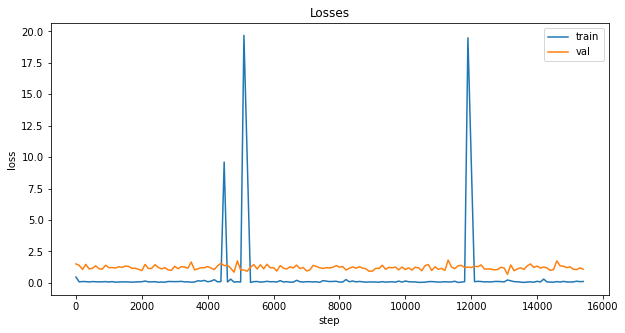

In [27]:
# Chart losses
losses = pd.DataFrame(all_losses)
losses['step'] = losses.index * eval_interval
fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(x='step', y='train', data=losses, ax=ax, label='train')
sns.lineplot(x='step', y='val', data=losses, ax=ax, label='val')
ax.set_xlabel('step')
ax.set_ylabel('loss')
ax.set_title('Losses')
plt.show()

In [20]:
# Extract the item embeddings format he model
pos_embd = torch.Tensor.cpu(model.transformer.wpe.weight.data) # gpt
pos_embd.shape
# Fit umap
umap_2d = umap.UMAP(n_components=2, init='random', random_state=0)
proj_2d = umap_2d.fit_transform(pos_embd)
# Plot the embeddings
data = pd.DataFrame(proj_2d, columns=['x', 'y'])
data.index.name = "pos"
data = data.reset_index()

fig = px.scatter(
    data, x='x', y='y',
    hover_data=['pos'],
    color="pos",
    width=600, height=400
)
fig.show()

In [22]:
X, Y = get_batch("val", TARGET_PERIOD, trans_func)
logits, loss = model(X, Y)
print("X", X[0], X.shape)
print("Y", Y[0], Y.shape)
print("logits", logits[0], logits.shape)
print("loss", loss)

X tensor([0.3475, 0.1969, 0.1390, 0.0695, 0.0347, 0.0695, 0.0000, 0.3359, 0.1544,
        0.4402, 0.3012, 0.1120, 0.5174, 0.2162, 0.5135, 0.5753, 0.5637, 0.4981,
        0.6139, 0.7683, 1.0000, 0.3436, 0.6139, 0.4208, 0.2741, 0.2432, 0.1969,
        0.2201, 0.3012, 0.4981], device='cuda:0') torch.Size([128, 30])
Y tensor([0.1969, 0.1390, 0.0695, 0.0347, 0.0695, 0.0000, 0.3359, 0.1544, 0.4402,
        0.3012, 0.1120, 0.5174, 0.2162, 0.5135, 0.5753, 0.5637, 0.4981, 0.6139,
        0.7683, 1.0000, 0.3436, 0.6139, 0.4208, 0.2741, 0.2432, 0.1969, 0.2201,
        0.3012, 0.4981, 0.5753], device='cuda:0') torch.Size([128, 30])
logits tensor([0.9517, 0.9268, 0.8888, 0.9143, 0.9547, 0.9638, 0.9884, 0.6053, 0.6945,
        0.6812, 0.7196, 0.7342, 0.7129, 0.6736, 0.4583, 0.3888, 0.3307, 0.2889,
        0.2366, 0.3881, 0.4246, 0.4256, 0.4637, 0.4540, 0.3759, 0.4554, 0.4305,
        0.4247, 0.4349, 0.4970], device='cuda:0', grad_fn=<SelectBackward0>) torch.Size([128, 30])
loss tensor(30.8386, devic

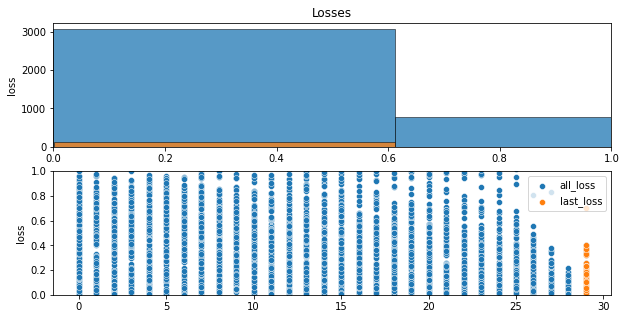

In [23]:
# Plot losses
losses = torch.abs(logits - Y).flatten()
last_losses = torch.abs(logits[:, -1] - Y[:, -1]).flatten()
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10, 5))
# Hist plot
sns.histplot(x=losses.detach().cpu().numpy(), bins=100, ax=ax1, label='all_loss')
sns.histplot(x=last_losses.detach().cpu().numpy(), bins=100, ax=ax1, label='last_loss')
ax1.set_ylabel('loss')
ax1.set_title('Losses')
ax1.set_xlim(0, 1)

# Scatter plot
sns.scatterplot(x=np.tile(np.arange(X.shape[1]), X.shape[0]), y=losses.detach().cpu().numpy(), ax=ax2, label='all_loss')
sns.scatterplot(x=np.ones((128)) * PERIOD-1, y=last_losses.detach().cpu().numpy(), ax=ax2, label='last_loss')
ax2.set_ylabel('loss')
ax2.set_ylim(0, 1)

plt.show()

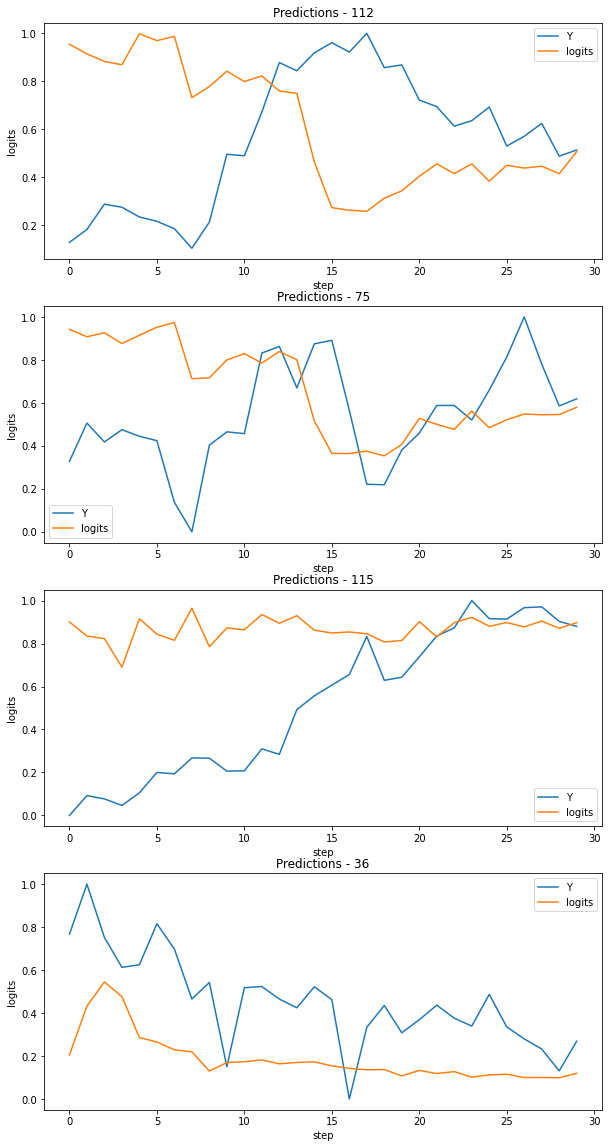

In [24]:
# Plot example predictions
idx = np.random.randint(0, 127, (4))
fig, axs = plt.subplots(nrows=4, figsize=(10, 20))
for ax, i in zip(axs, idx):
    sns.lineplot(x=np.arange(Y.shape[1]), y=Y[i].detach().cpu().numpy(), ax=ax, label='Y')
    sns.lineplot(x=np.arange(Y.shape[1]), y=logits[i].detach().cpu().numpy(), ax=ax, label='logits')
    ax.set_xlabel('step')
    ax.set_ylabel('logits')
    ax.set_title(f'Predictions - {i}')
plt.show()

In [25]:
# Save the model
torch.save(model, model_fp)
model_fp

'C:/Users/robert.franklin/Desktop/local_projects/random/stock-gpt/data/close_single_long_period30_pred1_norm_normsize30.pt'